# Scholarly Topic Navigator - Day 3 Complete Pipeline

## Integration, UI, and Explainability

**Team:** Aditya, Trisha, Pramod

---

### Day 3 Objectives:
1. Load Day 2 Components - Pre-labeled data, Embeddings, Pre-built Retrievers
2. Load Pre-Computed Categories - From papers_fully_labeled.parquet
3. Load Pre-Built Retrievers - BM25 + FAISS from cache
4. Summarization Engine - Extractive (TextRank) + Abstractive (BART)
5. Explainability Module - LIME for classification interpretability
6. Display Metrics - Show pre-computed evaluation results
7. Streamlit Dashboard - Full-featured UI with all visualizations


---
## 1. Setup & Installation

In [1]:
# Install required packages
!pip install streamlit sumy lime transformers torch matplotlib plotly \
    sentence-transformers rank_bm25 faiss-cpu nltk wordcloud \
    pandas numpy scikit-learn pyarrow seaborn pyngrok gensim bertopic \
    umap-learn hdbscan --quiet

print(" Installation complete!")

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 61.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Core imports
import os
import sys
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from collections import Counter

# ML & NLP
import torch
import faiss
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLTK setup for improved BM25 preprocessing
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    nltk.download('stopwords', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

print(f" All imports successful!")
print(f"   PyTorch version: {torch.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

2025-12-05 05:54:17.294320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764914057.472973      87 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764914057.523326      87 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

 All imports successful!
   PyTorch version: 2.6.0+cu124
   CUDA available: True
   GPU: Tesla T4


---
## 2. Configuration & Paths

In [3]:
# ============================================================
# PATH CONFIGURATION (Updated for Kaggle flat file structure)
# ============================================================

def detect_environment():
    """Detect runtime environment and return appropriate data root path."""
    # Check for local all_files_complete folder
    possible_local_paths = [
        Path('./all_files_complete'),
        Path('../all_files_complete'),
        Path('../../all_files_complete'),
    ]
    for p in possible_local_paths:
        if p.exists():
            return p.resolve()
    
    # Check for Streamlit utils structure
    if Path('./output_1').exists():
        return Path('./output_1')
    
    # Google Colab with Drive
    colab_paths = [
        Path('/content/drive/MyDrive/scholarly-topic-navigator'),
        Path('/content/drive/MyDrive/all_files_complete'),
    ]
    for p in colab_paths:
        if p.exists():
            return p
    
    # Kaggle - util-files-v1/output_1 structure
    kaggle_path = Path('/kaggle/input/util-files-v2/output_1')
    if kaggle_path.exists():
        return kaggle_path
    
    return Path('.')

# Detect environment
DATA_ROOT = detect_environment()

# For Kaggle flat structure: ALL files are directly in output_1
# No subdirectories like data/processed, data/retrieval, etc.
OUTPUT_DIR = DATA_ROOT  # Same as DATA_ROOT for flat structure
PROCESSED_DIR = DATA_ROOT  # papers_fully_labeled.parquet is directly here
RETRIEVAL_DIR = DATA_ROOT  # bm25_retriever.pkl, faiss_index.bin are here
CLASSIFICATION_DIR = DATA_ROOT  # taxonomy.json is here
TOPIC_DIR = DATA_ROOT  # topic_results.json is here
SUMMARIZATION_DIR = DATA_ROOT
VIZ_DIR = DATA_ROOT

# Working directory for generated files
WORKING_DIR = Path('/kaggle/working') if Path('/kaggle').exists() else Path('./working_output')
WORKING_DIR.mkdir(exist_ok=True)

print("Path Configuration:")
print(f"   DATA_ROOT: {DATA_ROOT}")
print(f"   OUTPUT_DIR: {OUTPUT_DIR}")
print(f"   PROCESSED_DIR: {PROCESSED_DIR}")
print(f"   WORKING_DIR: {WORKING_DIR}")

# Verify files exist
print("\nChecking required files...")
required_files = {
    'papers_fully_labeled.parquet': PROCESSED_DIR / 'papers_fully_labeled.parquet',
    'cleaned_papers.parquet': OUTPUT_DIR / 'cleaned_papers.parquet',
    'sbert_abstract_embeddings.npy': OUTPUT_DIR / 'sbert_abstract_embeddings.npy',
    'bm25_retriever.pkl': RETRIEVAL_DIR / 'bm25_retriever.pkl',
    'faiss_index.bin': RETRIEVAL_DIR / 'faiss_index.bin',
    'taxonomy.json': CLASSIFICATION_DIR / 'taxonomy.json',
    'topic_results.json': TOPIC_DIR / 'topic_results.json',
}

for name, path in required_files.items():
    status = "Y" if path.exists() else "X"
    print(f"   {status} {name}")


Path Configuration:
   DATA_ROOT: /kaggle/input/util-files-v2/output_1
   OUTPUT_DIR: /kaggle/input/util-files-v2/output_1
   PROCESSED_DIR: /kaggle/input/util-files-v2/output_1
   WORKING_DIR: /kaggle/working

Checking required files...
   Y papers_fully_labeled.parquet
   Y cleaned_papers.parquet
   Y sbert_abstract_embeddings.npy
   Y bm25_retriever.pkl
   Y faiss_index.bin
   Y taxonomy.json
   Y topic_results.json


In [4]:
# ============================================================
# LOAD PRE-LABELED DATA (Skip Zero-Shot Classification)
# ============================================================

print(" Loading DataFrame...")

# Prefer pre-labeled data if available
labeled_path = PROCESSED_DIR / 'papers_fully_labeled.parquet'
topics_path = PROCESSED_DIR / 'papers_with_topics.parquet'

if topics_path.exists():
    df = pd.read_parquet(topics_path)
    print(f"    Loaded {len(df):,} papers with topics from papers_with_topics.parquet")
elif labeled_path.exists():
    df = pd.read_parquet(labeled_path)
    print(f"    Loaded {len(df):,} papers with categories from papers_fully_labeled.parquet")
else:
    df = pd.read_parquet(OUTPUT_DIR / 'cleaned_papers.parquet')
    print(f"    Loaded {len(df):,} papers from cleaned_papers.parquet (no pre-computed categories)")

print(f"   Columns: {list(df.columns)}")

# Determine abstract column
abs_col = 'original_abstract' if 'original_abstract' in df.columns else 'abstract'
print(f"   Abstract column: {abs_col}")

# Load embeddings
print("\n Loading embeddings...")
sbert_embeddings = np.load(OUTPUT_DIR / 'sbert_abstract_embeddings.npy')
print(f"    SBERT embeddings: {sbert_embeddings.shape}")

# Check category status
if 'category' in df.columns:
    print(f"\n Category column exists: True")
    print(f"   Unique categories: {df['category'].nunique()}")
    print(f"\n Category Distribution:")
    print(df['category'].value_counts())
else:
    print(f"\n Category column exists: False")

# Check topic columns
topic_cols = ['kmeans_cluster', 'lda_topic', 'bertopic_topic']
available_topics = [col for col in topic_cols if col in df.columns]
if available_topics:
    print(f"\n Topic columns available: {available_topics}")

 Loading DataFrame...
    Loaded 22,522 papers with topics from papers_with_topics.parquet
   Columns: ['paper_id', 'title', 'authors', 'original_abstract', 'cleaned_text', 'language', 'sentences', 'n_sentences', 'tokens', 'processed_text', 'n_tokens', 'source', 'year', 'venue', 'category', 'text_feature', 'kmeans_cluster', 'lda_topic', 'bertopic_topic']
   Abstract column: original_abstract

 Loading embeddings...
    SBERT embeddings: (22522, 384)

 Category column exists: True
   Unique categories: 12

 Category Distribution:
category
ML_Methods                12356
Language_Models            4968
Applications               3569
Information_Extraction      363
QA_Dialogue                 316
Text_Generation             237
Speech_Audio                204
Vision_Language             193
Sentiment_Opinion           187
Machine_Translation          94
NLP_Core                     19
Ethics_Bias                  16
Name: count, dtype: int64

 Topic columns available: ['kmeans_cluster', 

---
## 3. Class Definitions

In [5]:
# =================================================================
# BM25 RETRIEVER - Keyword-based search with NLP preprocessing
# -----------------------------------------------------------------
print(20*'-' + 'Begin BM25 Retriever' + 20*'-')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from rank_bm25 import BM25Okapi

class BM25Retriever:
    def __init__(self, corpus=None, use_stemming=True, remove_stopwords=True):
        self.tokenized_corpus = None
        self.bm25 = None
        self.corpus = corpus
        self.use_stemming = use_stemming
        self.remove_stopwords = remove_stopwords
        self.stemmer = PorterStemmer() if use_stemming else None
        self.stop_words = set(stopwords.words('english')) if remove_stopwords else set()
        
        if corpus is not None:
            print("   Preprocessing corpus...")
            self.tokenized_corpus = [self._preprocess(doc) for doc in tqdm(corpus, desc="Tokenizing")]
            self.bm25 = BM25Okapi(self.tokenized_corpus)
    
    def _preprocess(self, text):
        # Tokenize, remove stopwords, stem
        tokens = word_tokenize(text.lower())
        tokens = [t for t in tokens if t.isalnum()]
        if self.remove_stopwords:
            tokens = [t for t in tokens if t not in self.stop_words]
        if self.use_stemming and self.stemmer:
            tokens = [self.stemmer.stem(t) for t in tokens]
        return tokens
    
    def search(self, query, top_k=10):
        tokenized_query = self._preprocess(query)
        scores = self.bm25.get_scores(tokenized_query)
        top_indices = np.argsort(scores)[::-1][:top_k]
        return [(idx, scores[idx]) for idx in top_indices]


# -----------------------------------------------------------------
# FAISS RETRIEVER - Semantic vector search
# -----------------------------------------------------------------

class FAISSRetriever:
    def __init__(self, embeddings=None, encoder_model='all-MiniLM-L6-v2'):
        self.encoder = SentenceTransformer(encoder_model)
        self.index = None
        self.dimension = None
        if embeddings is not None:
            self.embeddings = embeddings.astype('float32')
            self.dimension = embeddings.shape[1]
            faiss.normalize_L2(self.embeddings)
            self.index = faiss.IndexFlatIP(self.dimension)
            self.index.add(self.embeddings)
    
    def search(self, query, top_k=10):
        query_vec = self.encoder.encode([query], convert_to_numpy=True).astype('float32')
        faiss.normalize_L2(query_vec)
        scores, indices = self.index.search(query_vec, top_k)
        return [(int(idx), float(score)) for idx, score in zip(indices[0], scores[0])]
    
    def load_index(self, filepath):
        self.index = faiss.read_index(str(filepath))
        self.dimension = self.index.d


# -----------------------------------------------------------------
# HYBRID RETRIEVER - Combines BM25 + Semantic search
# -----------------------------------------------------------------

class HybridRetriever:
    def __init__(self, bm25_retriever, faiss_retriever, bm25_weight=0.3, semantic_weight=0.7):
        self.bm25 = bm25_retriever
        self.faiss = faiss_retriever
        self.bm25_weight = bm25_weight
        self.semantic_weight = semantic_weight
    
    def search(self, query, top_k=10, expand_k=50):
        bm25_results = self.bm25.search(query, top_k=expand_k)
        faiss_results = self.faiss.search(query, top_k=expand_k)
        
        bm25_scores = {idx: score for idx, score in bm25_results}
        faiss_scores = {idx: score for idx, score in faiss_results}
        all_indices = set(bm25_scores.keys()) | set(faiss_scores.keys())
        
        bm25_max = max(bm25_scores.values()) if bm25_scores else 1
        faiss_max = max(faiss_scores.values()) if faiss_scores else 1
        
        combined_results = []
        for idx in all_indices:
            bm25_score = bm25_scores.get(idx, 0) / bm25_max if bm25_max > 0 else 0
            faiss_score = faiss_scores.get(idx, 0) / faiss_max if faiss_max > 0 else 0
            combined_score = self.bm25_weight * bm25_score + self.semantic_weight * faiss_score
            combined_results.append((idx, combined_score))
        
        combined_results.sort(key=lambda x: x[1], reverse=True)
        return combined_results[:top_k]

print("Retriever classes defined")
print(20*'-' + 'End BM25 Retriever' + 20*'-')


--------------------Begin BM25 Retriever--------------------
Retriever classes defined
--------------------End BM25 Retriever--------------------


In [6]:
# =================================================================
# EMBEDDING CLASSIFIER - SBERT + Logistic Regression
# -----------------------------------------------------------------
print(20*'-' + 'Begin Classifier' + 20*'-')

class EmbeddingClassifier:
    def __init__(self, encoder_model='all-MiniLM-L6-v2'):
        self.encoder = SentenceTransformer(encoder_model)
        self.classifier = LogisticRegression(max_iter=1000, n_jobs=-1)
        self.label_encoder = None
        self.classes_ = None
    
    def fit(self, texts, labels, label_encoder=None):
        print("   Encoding texts...")
        embeddings = self.encoder.encode(texts, show_progress_bar=True, batch_size=32)
        
        print("   Training classifier...")
        self.classifier.fit(embeddings, labels)
        self.label_encoder = label_encoder
        if label_encoder:
            self.classes_ = list(label_encoder.classes_)
        else:
            self.classes_ = list(set(labels))
        print("   Training complete")
    
    def predict(self, texts):
        if isinstance(texts, str):
            texts = [texts]
        embeddings = self.encoder.encode(texts, show_progress_bar=False)
        predictions = self.classifier.predict(embeddings)
        if self.label_encoder:
            return self.label_encoder.inverse_transform(predictions)
        return predictions
    
    def predict_proba(self, texts):
        if isinstance(texts, str):
            texts = [texts]
        embeddings = self.encoder.encode(texts, show_progress_bar=False)
        return self.classifier.predict_proba(embeddings)
    
    def predict_with_confidence(self, text):
        proba = self.predict_proba(text)[0]
        pred_idx = np.argmax(proba)
        return {
            'predicted_class': self.classes_[pred_idx],
            'confidence': proba[pred_idx],
            'all_probabilities': dict(zip(self.classes_, proba))
        }

print("EmbeddingClassifier defined")
print(20*'-' + 'End Classifier' + 20*'-')


--------------------Begin Classifier--------------------
EmbeddingClassifier defined
--------------------End Classifier--------------------


---
## 4. Load Taxonomy and Metrics

Load pre-computed classification taxonomy and evaluation metrics from `all_files_complete`.

In [7]:
# ============================================================
# LOAD TAXONOMY AND PRE-COMPUTED METRICS
# ============================================================

print(" Loading taxonomy and metrics...")

# Load taxonomy
taxonomy_path = CLASSIFICATION_DIR / 'taxonomy.json'
if taxonomy_path.exists():
    with open(taxonomy_path, 'r') as f:
        taxonomy = json.load(f)
    CATEGORY_LABELS = list(taxonomy.keys())
    print(f"    Loaded taxonomy with {len(CATEGORY_LABELS)} categories:")
    for cat, info in taxonomy.items():
        print(f"      - {cat}: {info['description']}")
else:
    print("    Taxonomy not found, using default categories")
    CATEGORY_LABELS = [
        "ML_Methods", "Language_Models", "Applications", "Information_Extraction",
        "QA_Dialogue", "Text_Generation", "Speech_Audio", "Vision_Language",
        "Sentiment_Opinion", "Machine_Translation", "NLP_Core", "Ethics_Bias"
    ]

# Load classification metrics
print("\n Classification Metrics:")
metrics_path = CLASSIFICATION_DIR / 'metrics.json'
if metrics_path.exists():
    with open(metrics_path, 'r') as f:
        cls_metrics = json.load(f)
    print(f"   Method: {cls_metrics['method']}")
    print(f"   F1 Macro: {cls_metrics['f1_macro']:.4f}")
    print(f"   F1 Weighted: {cls_metrics['f1_weighted']:.4f}")
    print(f"   Train/Test: {cls_metrics['train_size']:,} / {cls_metrics['test_size']:,}")

# Load CV metrics
cv_path = CLASSIFICATION_DIR / 'cv_metrics.json'
if cv_path.exists():
    with open(cv_path, 'r') as f:
        cv_metrics = json.load(f)
    print(f"\n   Cross-Validation ({cv_metrics['n_folds']}-fold):")
    print(f"   F1 Macro: {cv_metrics['f1_macro_mean']:.4f} ± {cv_metrics['f1_macro_std']:.4f}")
    print(f"   Accuracy: {cv_metrics['accuracy_mean']:.4f} ± {cv_metrics['accuracy_std']:.4f}")

# Load error analysis
error_path = CLASSIFICATION_DIR / 'error_analysis.json'
if error_path.exists():
    with open(error_path, 'r') as f:
        error_analysis = json.load(f)
    print(f"\n   Error Analysis:")
    print(f"   Error Rate: {error_analysis['error_rate']:.2%}")
    print(f"   Top Confusion Pairs:")
    for pair, count in error_analysis['top_confusion_pairs'][:3]:
        print(f"      - {pair}: {count}")

# Load retrieval metrics
print("\n Retrieval Metrics:")
retrieval_path = RETRIEVAL_DIR / 'evaluation_results.json'
if retrieval_path.exists():
    with open(retrieval_path, 'r') as f:
        ret_metrics = json.load(f)
    for method, scores in ret_metrics.items():
        print(f"   {method.upper()}: MRR={scores['mrr']:.3f}, R@10={scores['recall@10']:.3f}")

# Load topic modeling results
print("\n Topic Modeling Results:")
topic_path = TOPIC_DIR / 'topic_results.json'
if topic_path.exists():
    with open(topic_path, 'r') as f:
        topic_results = json.load(f)
    print(f"   KMeans: {topic_results['kmeans']['n_clusters']} clusters")
    print(f"   LDA: {topic_results['lda']['n_topics']} topics (coherence: {topic_results['lda']['coherence_score']:.3f})")
    print(f"   BERTopic: {topic_results['bertopic']['n_topics']} topics")
else:
    topic_results = None

# Load summarization metrics
print("\n Summarization Metrics:")
rouge_path = SUMMARIZATION_DIR / 'rouge_metrics.json'
if rouge_path.exists():
    with open(rouge_path, 'r') as f:
        rouge_metrics = json.load(f)
    print(f"   TextRank ROUGE-1: {rouge_metrics['textrank']['rouge1_f1_mean']:.3f}")
    print(f"   BART ROUGE-1: {rouge_metrics['bart']['rouge1_f1_mean']:.3f}")

 Loading taxonomy and metrics...
    Loaded taxonomy with 12 categories:
      - NLP_Core: Core NLP tasks: parsing, tagging, syntax
      - Language_Models: Language modeling, transformers, LLMs
      - Machine_Translation: Neural and statistical machine translation
      - Sentiment_Opinion: Sentiment analysis, opinion mining
      - QA_Dialogue: Question answering and dialogue systems
      - Information_Extraction: NER, relation extraction, event extraction
      - Text_Generation: Summarization, text generation, paraphrasing
      - Vision_Language: Multimodal, vision-language tasks
      - Speech_Audio: Speech recognition and audio processing
      - ML_Methods: General ML methods applied to NLP
      - Ethics_Bias: Fairness, bias, ethics in NLP
      - Applications: Domain-specific applications

 Classification Metrics:

 Retrieval Metrics:

 Topic Modeling Results:
   KMeans: 10 clusters
   LDA: 10 topics (coherence: 0.406)
   BERTopic: 12 topics

 Summarization Metrics:


---
## 5. Build Retrievers

In [8]:
# ============================================================
# LOAD PRE-BUILT RETRIEVERS (or build if not cached)
# ============================================================

print(" Loading/Building retrieval system...")

# Try to load pre-built BM25 retriever
bm25_path = RETRIEVAL_DIR / 'bm25_retriever.pkl'
if bm25_path.exists():
    print("   Loading BM25 retriever from cache...")
    with open(bm25_path, 'rb') as f:
        bm25_retriever = pickle.load(f)
    print(f"    BM25 retriever loaded from cache")
else:
    print("   Building BM25 index (no cache found)...")
    corpus = (df['title'] + ' ' + df[abs_col].fillna('')).tolist()
    bm25_retriever = BM25Retriever(corpus, use_stemming=True, remove_stopwords=True)
    print(f"    BM25 index built with {len(corpus):,} documents")

# Try to load pre-built FAISS index
faiss_path = RETRIEVAL_DIR / 'faiss_index.bin'
if faiss_path.exists():
    print("   Loading FAISS index from cache...")
    faiss_retriever = FAISSRetriever()  # Empty init
    faiss_retriever.load_index(str(faiss_path))
    print(f"    FAISS index loaded (dim={faiss_retriever.dimension})")
else:
    print("   Building FAISS index (no cache found)...")
    faiss_retriever = FAISSRetriever(sbert_embeddings)
    print(f"    FAISS index built (dim={faiss_retriever.dimension})")

# Build Hybrid Retriever
hybrid_retriever = HybridRetriever(bm25_retriever, faiss_retriever)
print("    Hybrid retriever ready")

# Test retrieval
print("\n Testing retrieval...")
test_query = "transformer attention mechanism"
results = hybrid_retriever.search(test_query, top_k=3)
for i, (idx, score) in enumerate(results, 1):
    print(f"   [{i}] Score: {score:.3f} - {df.iloc[idx]['title'][:60]}...")

 Loading/Building retrieval system...
   Loading BM25 retriever from cache...
    BM25 retriever loaded from cache
   Loading FAISS index from cache...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

    FAISS index loaded (dim=384)
    Hybrid retriever ready

 Testing retrieval...
   [1] Score: 0.974 - Hierarchical Self-Attention: Generalizing Neural Attention M...
   [2] Score: 0.943 - A Unified Geometric Field Theory Framework for Transformers:...
   [3] Score: 0.913 - How Particle-System Random Batch Methods Enhance Graph Trans...


---
## 6. Summarization Engine

In [9]:
# ============================================================
# SUMMARIZATION FUNCTIONS
# ============================================================

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

def get_extractive_summary(text, num_sentences=3):
    """TextRank extractive summarization."""
    try:
        parser = PlaintextParser.from_string(text, Tokenizer('english'))
        stemmer = Stemmer('english')
        summarizer = TextRankSummarizer(stemmer)
        summarizer.stop_words = get_stop_words('english')
        summary = summarizer(parser.document, num_sentences)
        return ' '.join([str(s) for s in summary])
    except:
        sentences = text.split('.')[:num_sentences]
        return '. '.join(sentences) + '.'

# Load BART for abstractive summarization
print("Loading BART summarizer...")
from transformers import pipeline as hf_pipeline

BART_AVAILABLE = False
try:
    device = 0 if torch.cuda.is_available() else -1
    bart_summarizer = hf_pipeline(
        'summarization',
        model='facebook/bart-large-cnn',
        device=device,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    BART_AVAILABLE = True
    print(" BART summarizer loaded")
except Exception as e:
    print(f" BART loading failed: {e}")
    bart_summarizer = None

def get_abstractive_summary(text, max_length=130, min_length=30):
    """BART abstractive summarization."""
    if not BART_AVAILABLE:
        return get_extractive_summary(text, 2)
    try:
        result = bart_summarizer(text[:1024], max_length=max_length, min_length=min_length, do_sample=False)
        return result[0]['summary_text']
    except:
        return get_extractive_summary(text, 2)

# Test summarization
print("\n Testing summarization...")
test_text = df.iloc[0][abs_col][:500]
print(f"   Extractive: {get_extractive_summary(test_text, 2)[:100]}...")

Loading BART summarizer...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


 BART summarizer loaded

 Testing summarization...
   Extractive: In real-world applications, the input text is typically the output of an automatic speech recognitio...


---
## 7. Explainability Module (LIME)

In [10]:
# =================================================================
# LIME EXPLAINER - Model interpretability
# -----------------------------------------------------------------
print(20*'-' + 'Begin LIME Explainer' + 20*'-')

from lime.lime_text import LimeTextExplainer

class ClassificationExplainer:
    def __init__(self, classifier, class_names):
        self.classifier = classifier
        self.class_names = class_names
        self.explainer = LimeTextExplainer(
            class_names=class_names,
            split_expression=r'\W+',
            bow=True
        )
    
    def explain_prediction(self, text, num_features=10, num_samples=200):
        explanation = self.explainer.explain_instance(
            text,
            self.classifier.predict_proba,
            num_features=num_features,
            num_samples=num_samples
        )
        return explanation
    
    def visualize_explanation(self, explanation, figsize=(10, 6)):
        fig = explanation.as_pyplot_figure()
        fig.set_size_inches(figsize)
        plt.tight_layout()
        return fig
    
    def get_word_importance(self, explanation):
        return explanation.as_list()

print("ClassificationExplainer defined")
print(20*'-' + 'End LIME Explainer' + 20*'-')


--------------------Begin LIME Explainer--------------------
ClassificationExplainer defined
--------------------End LIME Explainer--------------------


In [11]:
# ============================================================
# BUILD CLASSIFIER FOR EXPLAINABILITY (FIXED - Filter Unclassified)
# ============================================================

print(" Building classifier for explainability...")

# Check if category column exists
if 'category' not in df.columns:
    print("    No category column found. Skipping classifier training.")
    embedding_classifier = None
    explainer = None
else:
    # Filter out "Unclassified" papers and ensure valid categories
    train_df = df.dropna(subset=['category', abs_col]).copy()
    
    # Remove "Unclassified" category if present
    if 'Unclassified' in train_df['category'].values:
        before_count = len(train_df)
        train_df = train_df[train_df['category'] != 'Unclassified']
        print(f"   Filtered out {before_count - len(train_df)} 'Unclassified' papers")
    
    # Filter to only valid taxonomy categories if taxonomy exists
    if 'taxonomy' in dir() and taxonomy:
        valid_categories = list(taxonomy.keys())
        train_df = train_df[train_df['category'].isin(valid_categories)]
        print(f"   Using {len(valid_categories)} categories from taxonomy")
    
    categories = train_df['category'].unique().tolist()
    print(f"   Found {len(categories)} categories: {categories[:5]}{'...' if len(categories) > 5 else ''}")
    
    # Initialize classifier
    embedding_classifier = EmbeddingClassifier()
    
    # Stratified sampling for balanced training
    sample_size = min(3000, len(train_df))
    
    if len(train_df) > sample_size:
        # Ensure minimum samples per category for stratification
        min_per_cat = max(10, sample_size // len(categories))
        sampled_dfs = []
        for cat in categories:
            cat_df = train_df[train_df['category'] == cat]
            n_samples = min(len(cat_df), max(min_per_cat, int(len(cat_df) * sample_size / len(train_df))))
            if len(cat_df) >= 2:  # Need at least 2 samples for stratification
                sampled_dfs.append(cat_df.sample(n=min(n_samples, len(cat_df)), random_state=42))
        train_df = pd.concat(sampled_dfs)
        print(f"   Stratified sampling: {len(train_df)} samples")
    
    label_encoder = LabelEncoder()
    train_labels = label_encoder.fit_transform(train_df['category'])
    train_texts = train_df[abs_col].tolist()
    
    print(f"   Training on {len(train_texts)} samples across {len(label_encoder.classes_)} categories...")
    embedding_classifier.fit(train_texts, train_labels, label_encoder)
    
    # Create explainer with proper class names
    explainer = ClassificationExplainer(embedding_classifier, list(label_encoder.classes_))
    print(" Classifier and Explainer ready")

 Building classifier for explainability...
   Using 12 categories from taxonomy
   Found 12 categories: ['Applications', 'ML_Methods', 'Language_Models', 'NLP_Core', 'Information_Extraction']...
   Stratified sampling: 4231 samples
   Training on 4231 samples across 12 categories...
   Encoding texts...


Batches:   0%|          | 0/133 [00:00<?, ?it/s]

   Training classifier...
   Training complete
 Classifier and Explainer ready


--------------------Begin Explainability Test--------------------
Test Text: Recommender systems often rely on large embedding tables that map users and items to dense vectors of uniform size, leading to substantial memory consumption and inefficiencies. This is particularly p...
Actual Category: ML_Methods

Prediction: ML_Methods
Confidence: 76.26%
Correct: Yes

Top 3 Category Probabilities:
   ML_Methods: 76.26% <--
   Applications: 8.51% 
   QA_Dialogue: 4.43% 

Generating LIME explanation...

Top Contributing Words:
   - Training: -0.0024
   - Sparse: -0.0014
   - methods: -0.0008
   + Things: 0.0007
   + users: 0.0007
   - pruning: -0.0006
   - embedding: -0.0006
   - Dynamic: -0.0005
   - Recommender: -0.0005
   + environments: 0.0005


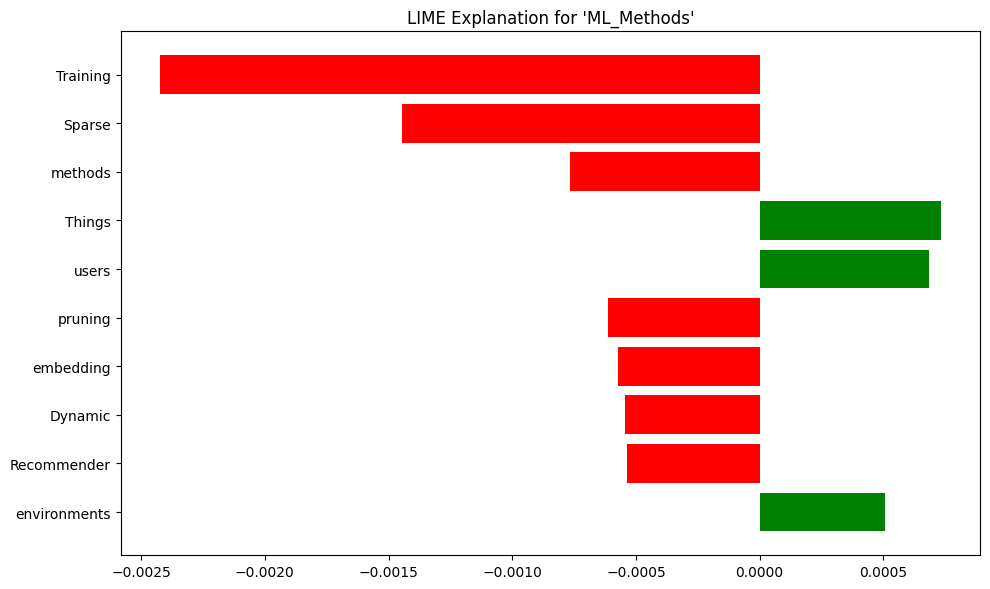

--------------------End Explainability Test--------------------


In [12]:
# =================================================================
# TEST EXPLAINABILITY
# -----------------------------------------------------------------
print(20*'-' + 'Begin Explainability Test' + 20*'-')

if embedding_classifier is not None and explainer is not None:
    # Get categories with enough samples
    category_counts = df['category'].value_counts()
    well_represented = category_counts[category_counts >= 100].index.tolist()
    
    # Filter to categories in trained model
    valid_for_test = [c for c in well_represented if c in label_encoder.classes_]
    
    if len(valid_for_test) > 0:
        test_category = valid_for_test[0]
        test_df = df[(df['category'] == test_category) & df[abs_col].notna()]
        
        if len(test_df) > 0:
            test_idx = test_df.sample(1, random_state=42).index[0]
            test_text = df.loc[test_idx, abs_col][:500]
            actual_category = df.loc[test_idx, 'category']
            
            print(f"Test Text: {test_text[:200]}...")
            print(f"Actual Category: {actual_category}")
            
            # Get prediction
            prediction = embedding_classifier.predict_with_confidence(test_text)
            is_correct = prediction['predicted_class'] == actual_category
            
            print(f"\nPrediction: {prediction['predicted_class']}")
            print(f"Confidence: {prediction['confidence']:.2%}")
            print(f"Correct: {'Yes' if is_correct else 'No'}")
            
            # Top 3 predictions
            print("\nTop 3 Category Probabilities:")
            sorted_probs = sorted(prediction['all_probabilities'].items(), key=lambda x: x[1], reverse=True)[:3]
            for cat, prob in sorted_probs:
                marker = "<--" if cat == actual_category else ""
                print(f"   {cat}: {prob:.2%} {marker}")
            
            # LIME explanation
            print("\nGenerating LIME explanation...")
            explanation = explainer.explain_prediction(test_text, num_features=10, num_samples=500)
            
            print("\nTop Contributing Words:")
            for word, weight in explanation.as_list()[:10]:
                direction = "+" if weight > 0 else "-"
                print(f"   {direction} {word}: {weight:.4f}")
            
            # Save visualization
            fig = explainer.visualize_explanation(explanation)
            plt.title(f"LIME Explanation for '{prediction['predicted_class']}'")
            plt.tight_layout()
            plt.savefig(WORKING_DIR / 'lime_explanation.png', dpi=150, bbox_inches='tight')
            plt.show()
        else:
            print("Warning: No valid test samples found")
    else:
        print("Warning: No well-represented categories found")
else:
    print("Warning: Classifier not available")

print(20*'-' + 'End Explainability Test' + 20*'-')


---
## 8. Display Topic Modeling Results

Show pre-computed topic modeling results from KMeans, LDA, and BERTopic.

In [13]:
# ============================================================
# DISPLAY TOPIC MODELING RESULTS
# ============================================================

print(" Topic Modeling Analysis")
print("="*60)

if topic_results:
    # KMeans Topics
    print("\n K-MEANS CLUSTERING")
    print(f"   Number of clusters: {topic_results['kmeans']['n_clusters']}")
    print("\n   Top terms per cluster:")
    for cluster_id, terms in list(topic_results['kmeans']['top_terms'].items())[:5]:
        print(f"   Cluster {cluster_id}: {', '.join(terms[:7])}")
    
    # LDA Topics
    print("\n LDA TOPIC MODELING")
    print(f"   Number of topics: {topic_results['lda']['n_topics']}")
    print(f"   Coherence score: {topic_results['lda']['coherence_score']:.4f}")
    print(f"   Optimal topics (by coherence): {topic_results['lda']['optimal_topics']}")
    print("\n   Sample topics:")
    for topic_id, topic_str in list(topic_results['lda']['topics'].items())[:3]:
        # Parse topic string to show cleaner format
        terms = [t.split('*')[1].strip('"') for t in topic_str.split(' + ')[:5]]
        print(f"   Topic {topic_id}: {', '.join(terms)}")
    
    # BERTopic
    print("\n BERTOPIC")
    print(f"   Number of topics: {topic_results['bertopic']['n_topics']}")
    topic_info = topic_results['bertopic']['topic_info']
    print("\n   Topic distribution:")
    for i in range(min(5, len(topic_info['Topic']))):
        topic_id = topic_info['Topic'][str(i)]
        count = topic_info['Count'][str(i)]
        name = topic_info['Name'][str(i)]
        print(f"   Topic {topic_id}: {count:,} docs - {name}")
else:
    print("    Topic results not available")

# Show topic distribution in dataframe if available
if 'bertopic_topic' in df.columns:
    print("\n BERTopic Distribution in Dataset:")
    print(df['bertopic_topic'].value_counts().head(10))

 Topic Modeling Analysis

 K-MEANS CLUSTERING
   Number of clusters: 10

   Top terms per cluster:
   Cluster 0: text, language, model, speech, word, task, entity
   Cluster 1: reasoning, model, llm, cot, language, step, chain
   Cluster 2: algorithm, distribution, function, problem, sample, method, gradient
   Cluster 3: model, datum, method, learning, time, use, base
   Cluster 4: image, visual, video, multimodal, model, modality, text

 LDA TOPIC MODELING
   Number of topics: 10
   Coherence score: 0.4056
   Optimal topics (by coherence): 15

   Sample topics:
   Topic 0: user, recommendation, item, preference, system
   Topic 1: llm, language, reasoning, large, evaluation
   Topic 2: training, performance, task, token, large

 BERTOPIC
   Number of topics: 12

   Topic distribution:
   Topic 0: 19,497 docs - 0_the_and_to_of
   Topic 1: 546 docs - 1_causal_the_of_and
   Topic 2: 173 docs - 2_quantum_the_classical_of
   Topic 3: 880 docs - 3_the_of_and_we
   Topic 4: 151 docs - 4_clu

---
## 9. Load/Generate Visualizations

Load pre-generated visualizations from `all_files_complete` or generate new ones if not available.

Generating Comprehensive Visualizations...

1. Category Distribution...


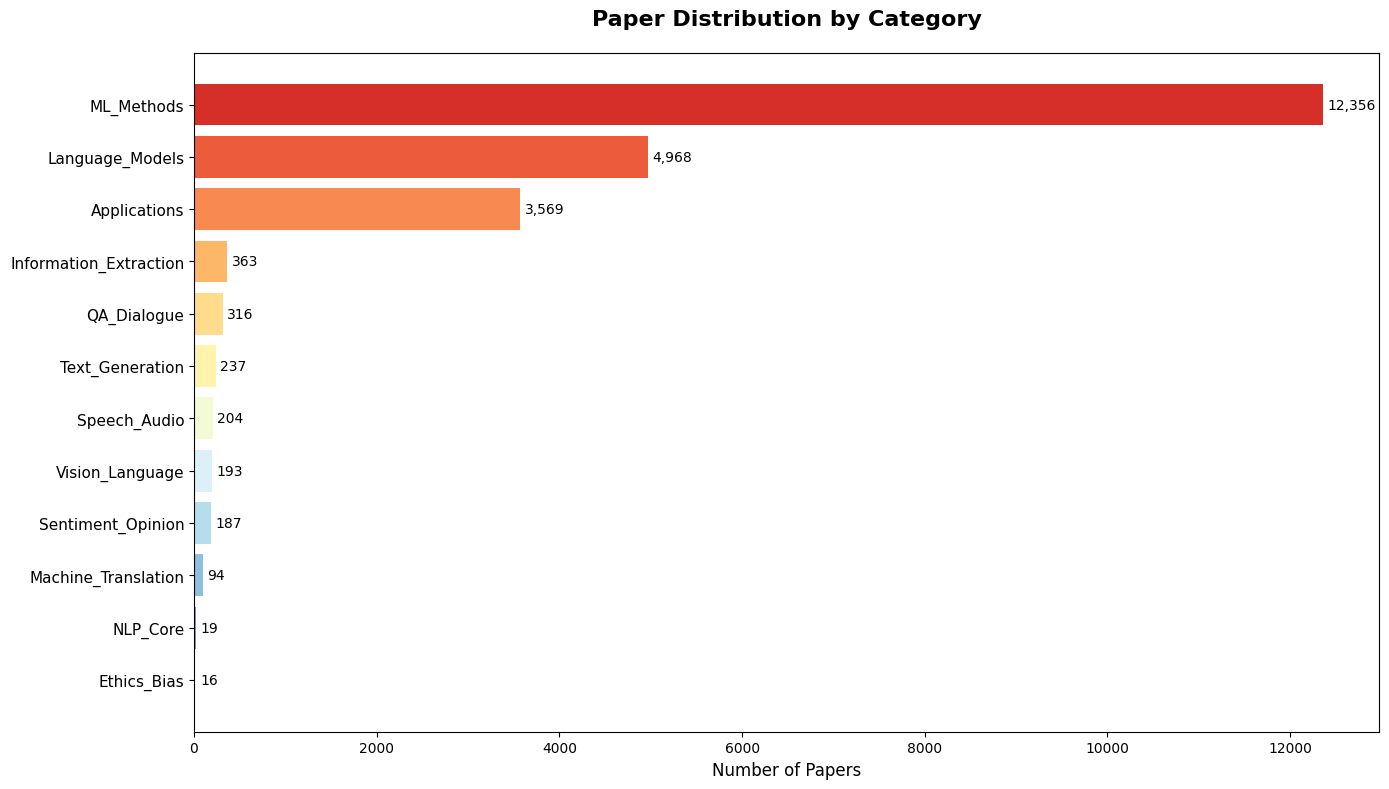


2. Category Pie Chart...


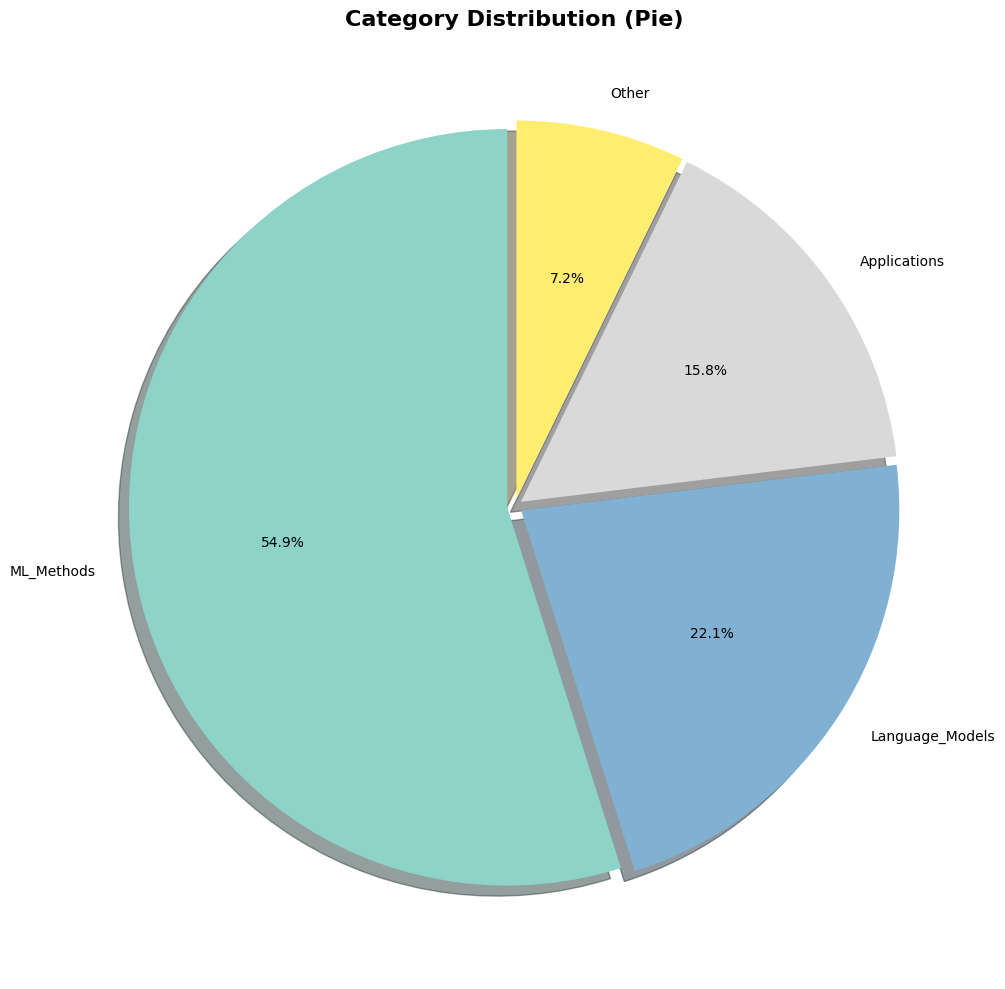


3. Data Source Distribution...


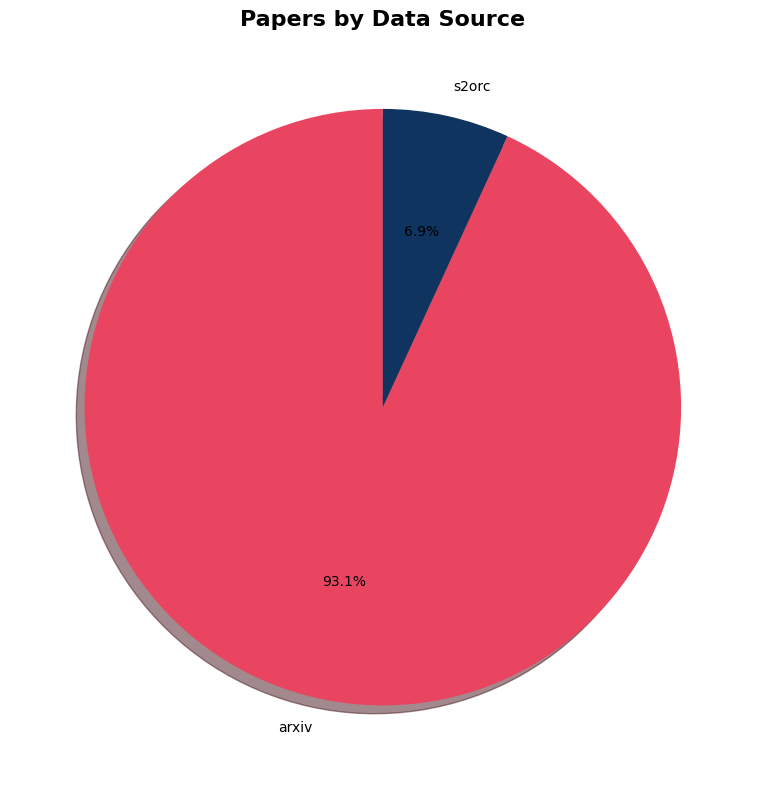


4. Publication Year Timeline...


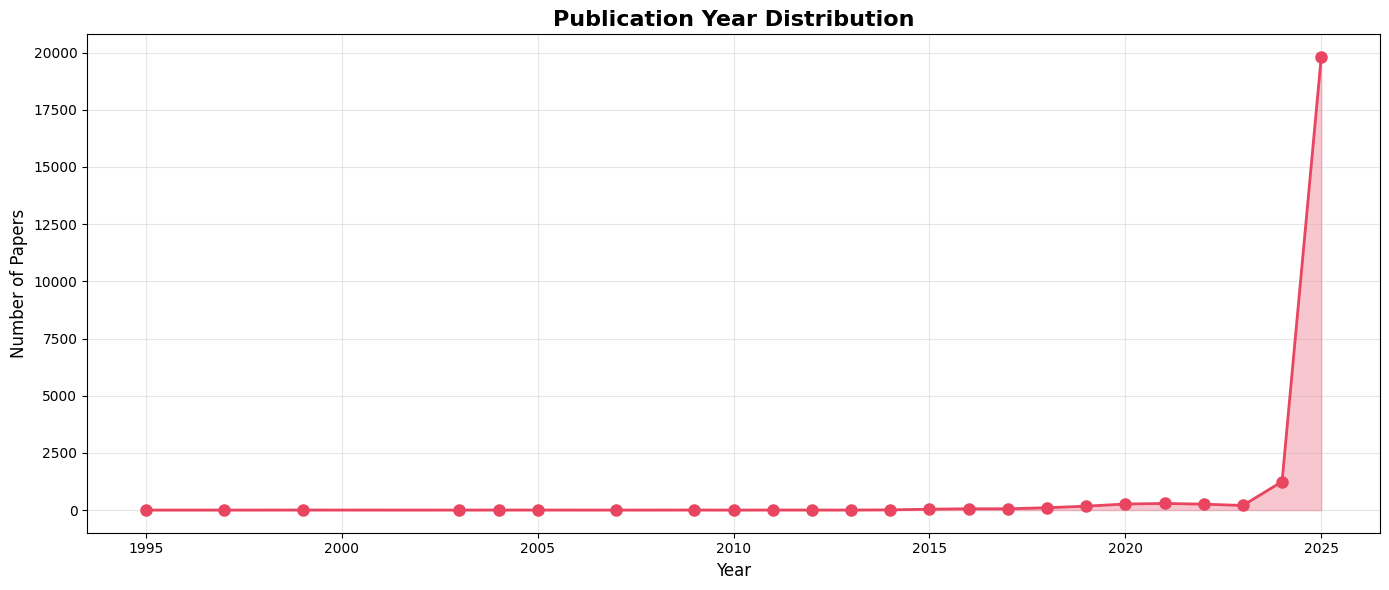


5. Category Word Clouds...


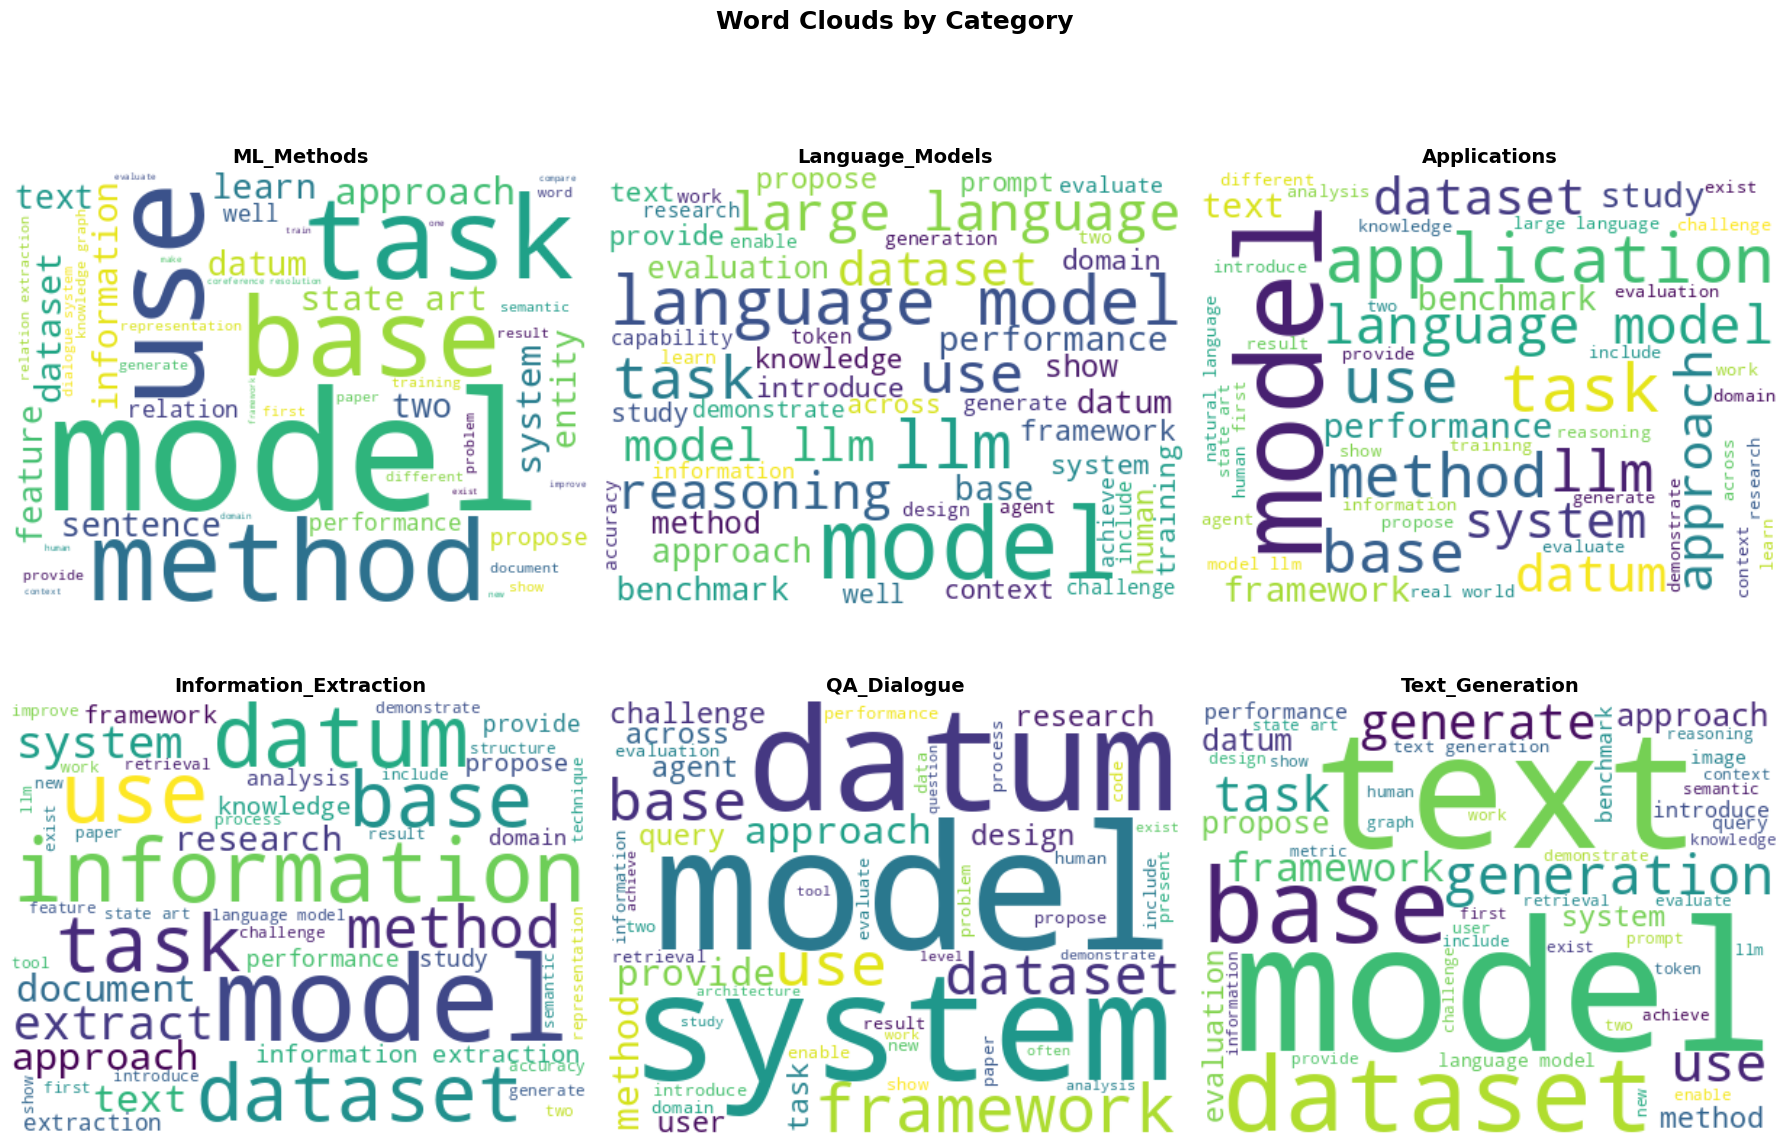


6. Topic Modeling Results (3 methods)...


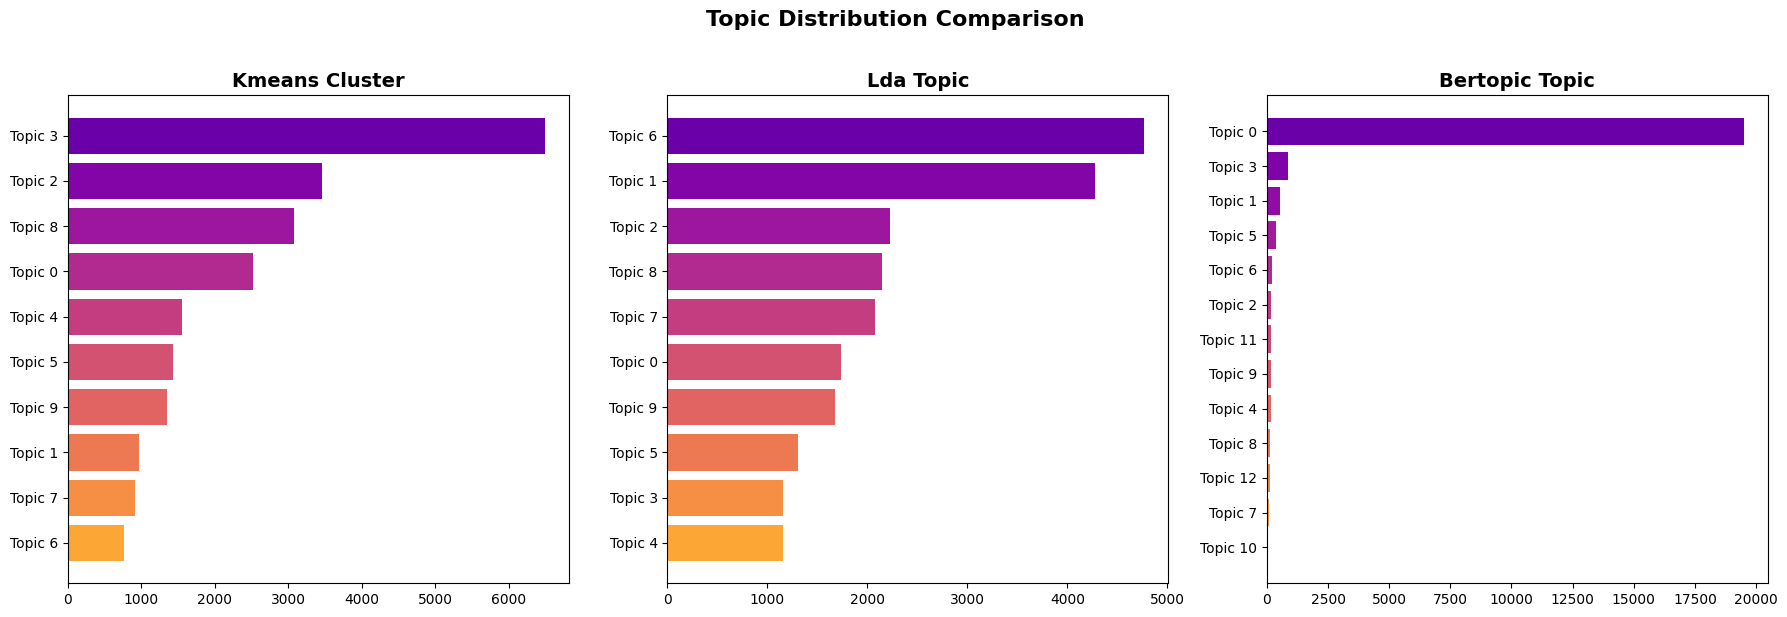


7. Classification Confidence Distribution...


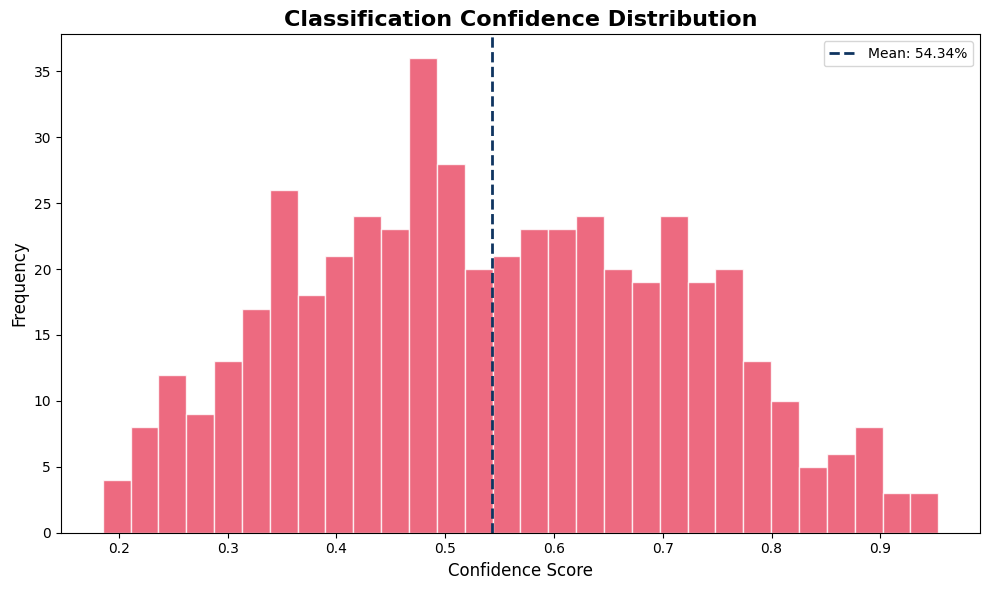


8. Embedding Space Visualization (t-SNE)...


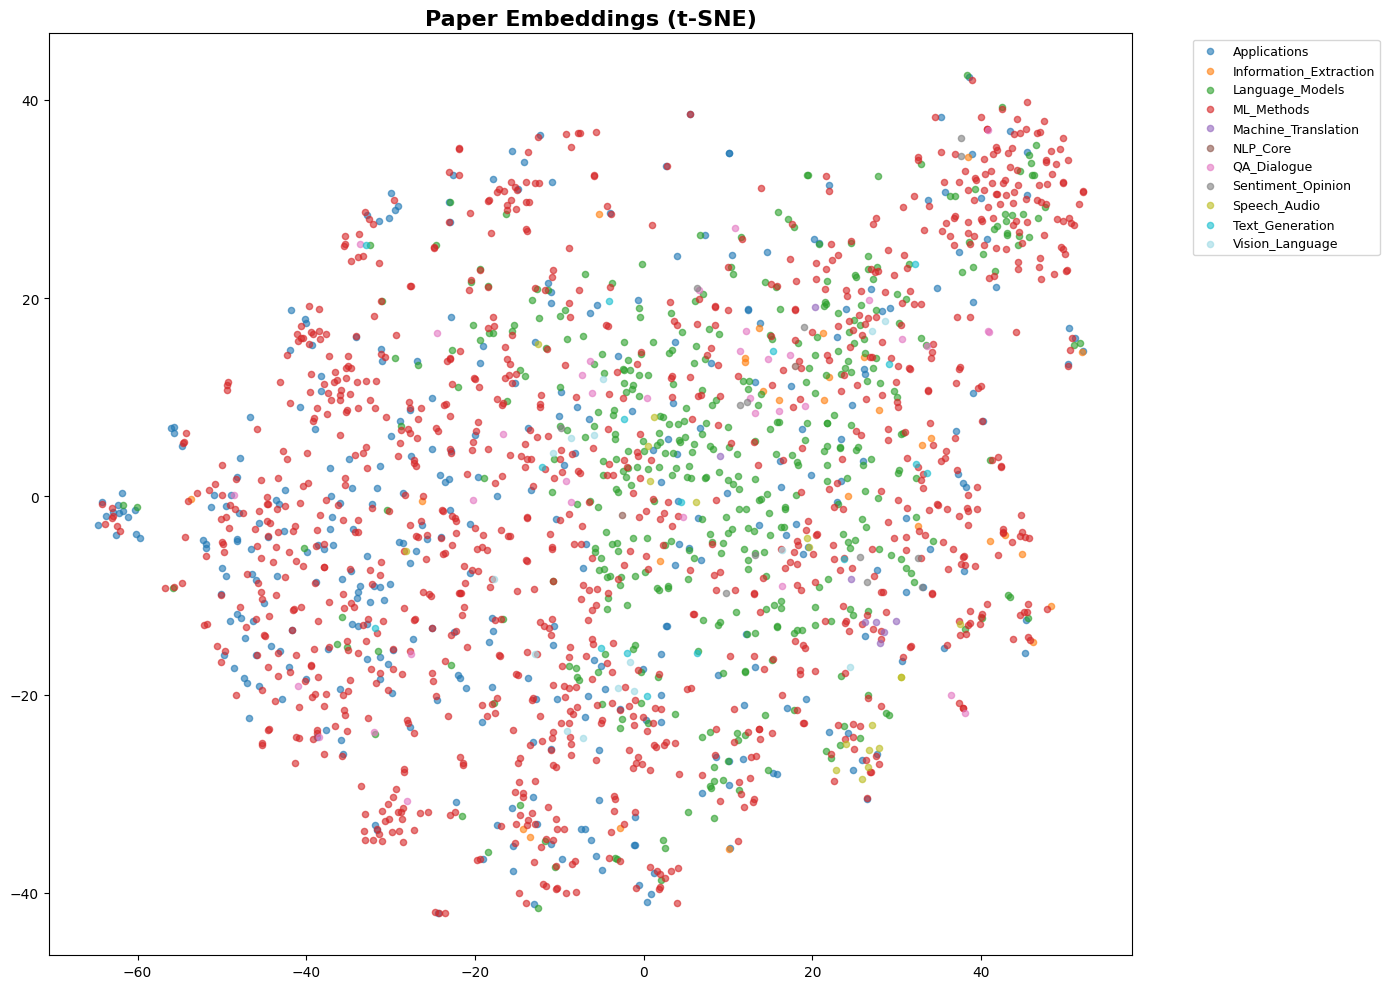


9. Abstract Length Distribution...


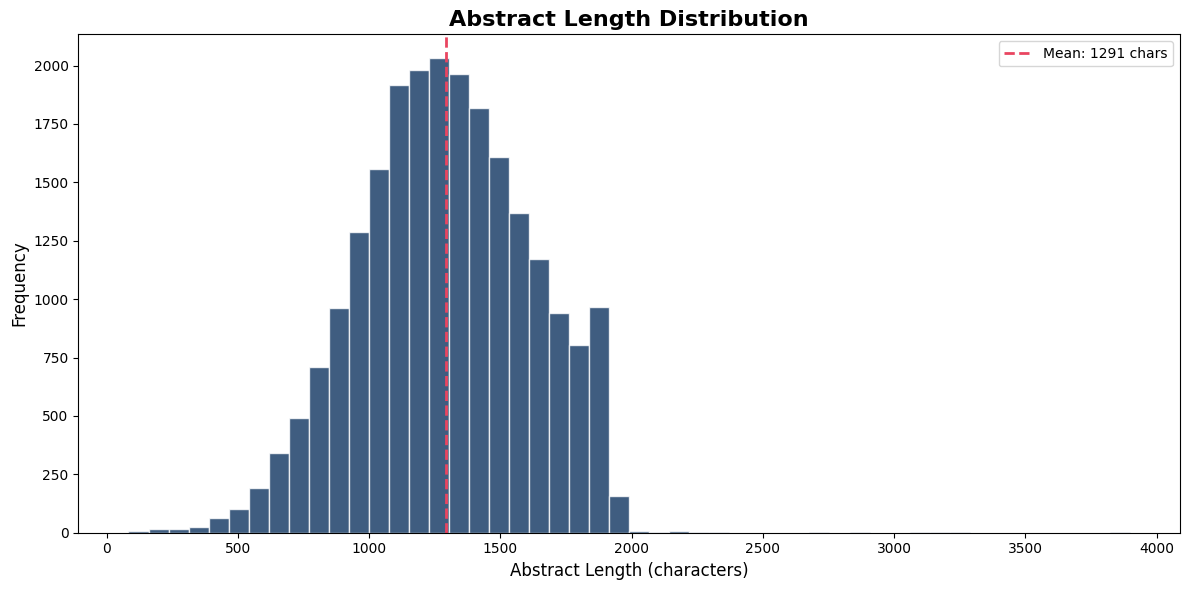


10. Creating Comprehensive Dashboard...


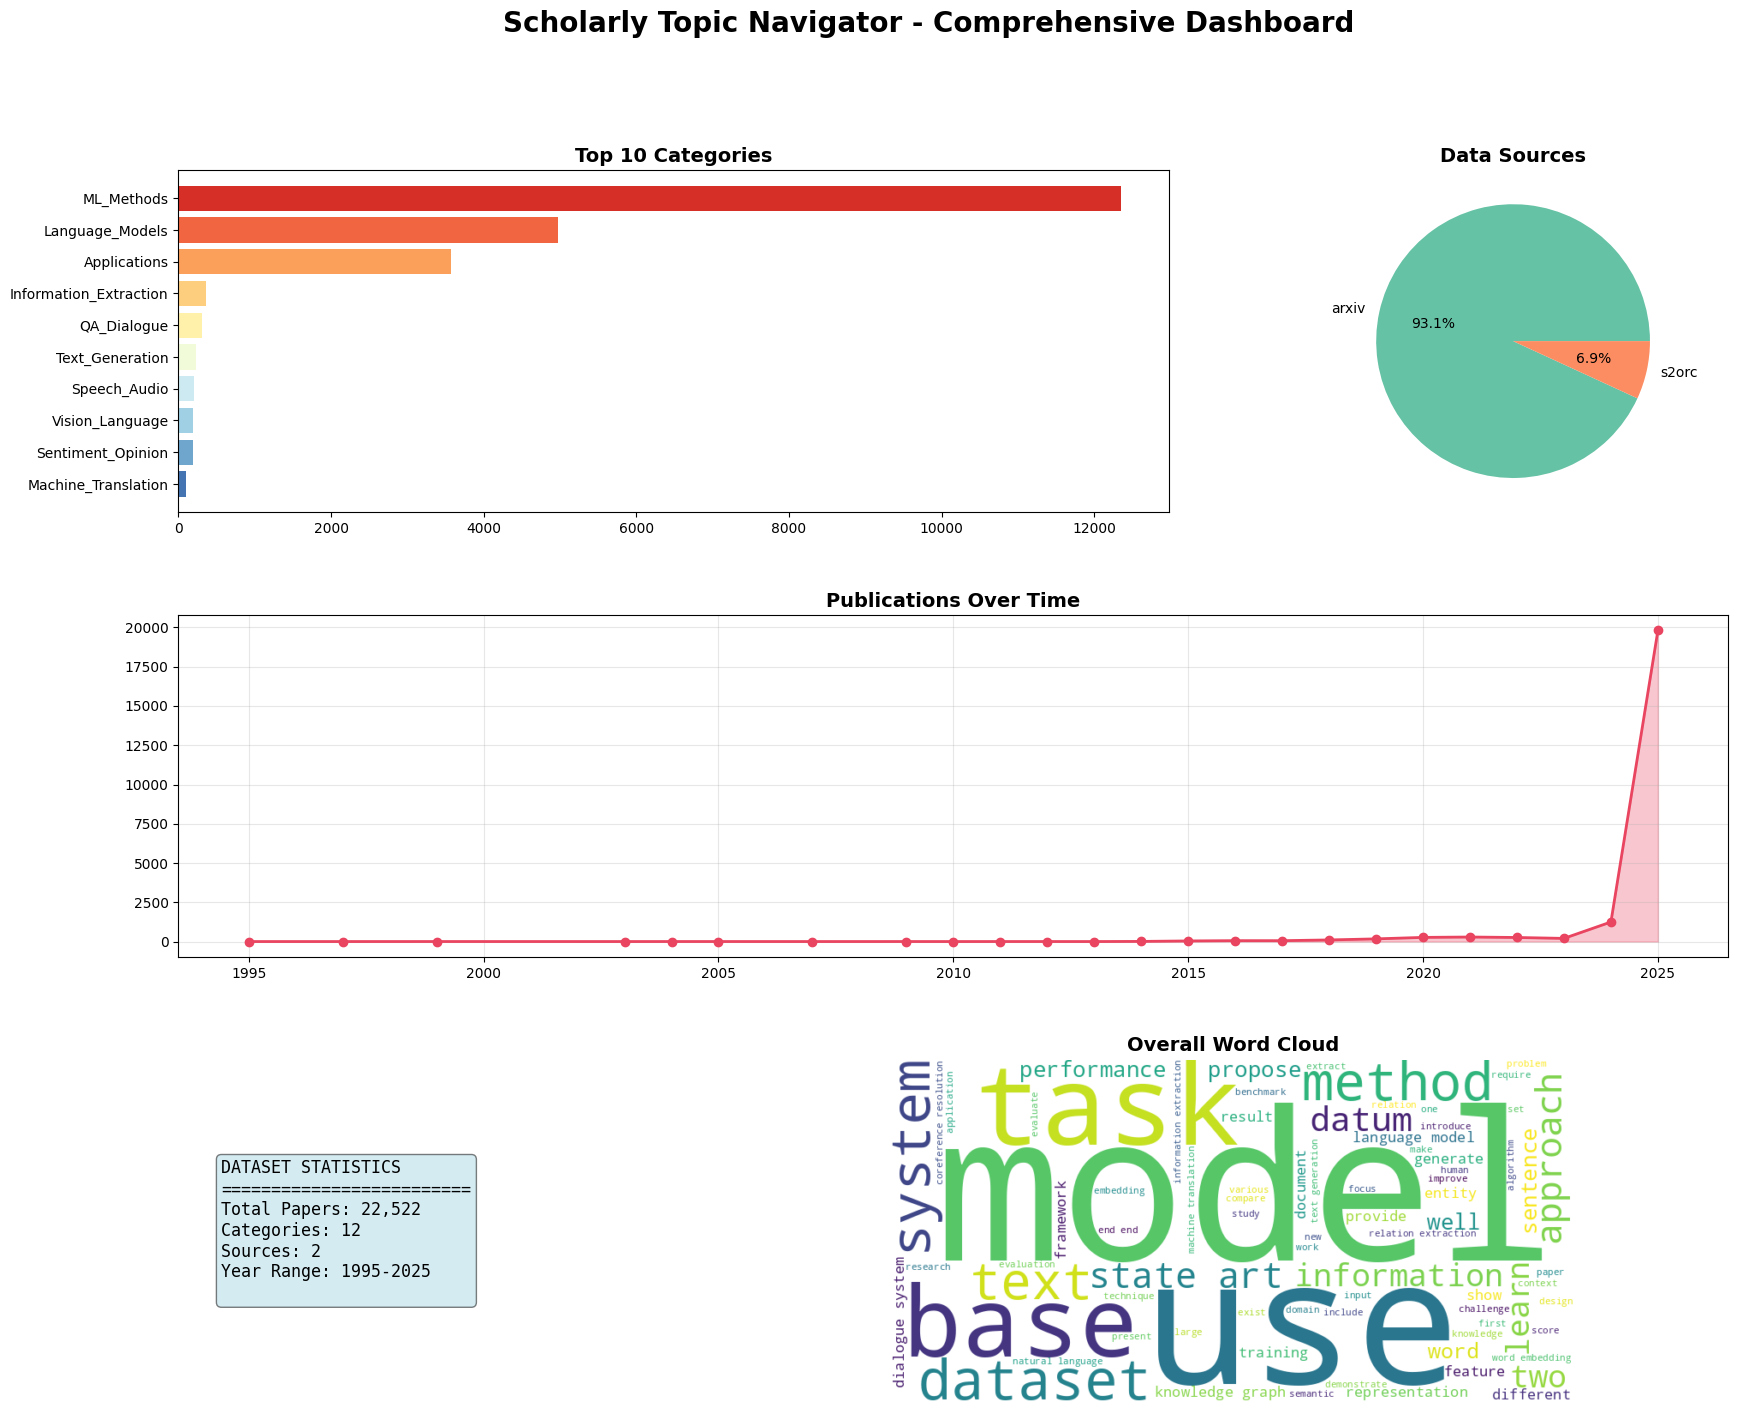


VISUALIZATION GENERATION COMPLETE
Generated 10 visualizations:
   - category_distribution.png
   - category_pie.png
   - source_distribution.png
   - year_distribution.png
   - category_wordclouds.png
   - topic_modeling_comparison.png
   - classification_confidence.png
   - embedding_tsne.png
   - abstract_length.png
   - comprehensive_dashboard.png

Saved to: /kaggle/working/visualizations


In [14]:
# ============================================================
# LOAD PRE-GENERATED VISUALIZATIONS (or generate comprehensive set)
# ============================================================
from IPython.display import Image, display
import json

print("Generating Comprehensive Visualizations...")
print("="*60)

# Create output directory
OUTPUT_VIZ_DIR = WORKING_DIR / 'visualizations'
OUTPUT_VIZ_DIR.mkdir(exist_ok=True)

generated_viz = []

# ============================================================
# 1. CATEGORY DISTRIBUTION (Bar Chart)
# ============================================================
if 'category' in df.columns:
    print("\n1. Category Distribution...")
    fig, ax = plt.subplots(figsize=(14, 8))
    cat_counts = df['category'].value_counts()
    colors = plt.cm.RdYlBu(np.linspace(0.1, 0.9, len(cat_counts)))
    bars = ax.barh(range(len(cat_counts)), cat_counts.values, color=colors)
    ax.set_yticks(range(len(cat_counts)))
    ax.set_yticklabels(cat_counts.index, fontsize=11)
    ax.set_xlabel('Number of Papers', fontsize=12)
    ax.set_title('Paper Distribution by Category', fontsize=16, fontweight='bold', pad=20)
    ax.invert_yaxis()
    
    # Add value labels
    for bar, val in zip(bars, cat_counts.values):
        ax.text(val + 50, bar.get_y() + bar.get_height()/2, f'{val:,}', 
                va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_VIZ_DIR / 'category_distribution.png', dpi=150, bbox_inches='tight')
    generated_viz.append('category_distribution.png')
    plt.show()
    plt.close()

# ============================================================
# 2. CATEGORY PIE CHART
# ============================================================
if 'category' in df.columns:
    print("\n2. Category Pie Chart...")
    fig, ax = plt.subplots(figsize=(12, 10))
    cat_counts = df['category'].value_counts()
    
    # Group small categories into 'Other'
    threshold = len(df) * 0.02
    main_cats = cat_counts[cat_counts >= threshold]
    other_count = cat_counts[cat_counts < threshold].sum()
    if other_count > 0:
        main_cats['Other'] = other_count
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(main_cats)))
    wedges, texts, autotexts = ax.pie(main_cats.values, labels=main_cats.index, 
                                       autopct='%1.1f%%', colors=colors, 
                                       explode=[0.02]*len(main_cats),
                                       shadow=True, startangle=90)
    ax.set_title('Category Distribution (Pie)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_VIZ_DIR / 'category_pie.png', dpi=150, bbox_inches='tight')
    generated_viz.append('category_pie.png')
    plt.show()
    plt.close()

# ============================================================
# 3. DATA SOURCE DISTRIBUTION
# ============================================================
if 'source' in df.columns:
    print("\n3. Data Source Distribution...")
    fig, ax = plt.subplots(figsize=(10, 8))
    source_counts = df['source'].value_counts()
    colors = ['#e94560', '#0f3460', '#16213e', '#1a1a2e', '#533483'][:len(source_counts)]
    wedges, texts, autotexts = ax.pie(source_counts.values, labels=source_counts.index,
                                       autopct='%1.1f%%', colors=colors,
                                       shadow=True, startangle=90)
    ax.set_title('Papers by Data Source', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_VIZ_DIR / 'source_distribution.png', dpi=150, bbox_inches='tight')
    generated_viz.append('source_distribution.png')
    plt.show()
    plt.close()

# ============================================================
# 4. YEAR DISTRIBUTION (Timeline)
# ============================================================
if 'year' in df.columns:
    print("\n4. Publication Year Timeline...")
    fig, ax = plt.subplots(figsize=(14, 6))
    year_counts = df['year'].value_counts().sort_index()
    ax.fill_between(year_counts.index, year_counts.values, alpha=0.3, color='#e94560')
    ax.plot(year_counts.index, year_counts.values, 'o-', color='#e94560', linewidth=2, markersize=8)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Number of Papers', fontsize=12)
    ax.set_title('Publication Year Distribution', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_VIZ_DIR / 'year_distribution.png', dpi=150, bbox_inches='tight')
    generated_viz.append('year_distribution.png')
    plt.show()
    plt.close()

# ============================================================
# 5. CATEGORY WORD CLOUDS
# ============================================================
if 'category' in df.columns and 'processed_text' in df.columns:
    print("\n5. Category Word Clouds...")
    top_cats = df['category'].value_counts().head(6).index.tolist()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, cat in enumerate(top_cats):
        text = ' '.join(df[df['category'] == cat]['processed_text'].fillna('').head(500))
        if len(text) > 100:
            wc = WordCloud(width=400, height=300, background_color='white',
                          colormap='viridis', max_words=50).generate(text)
            axes[i].imshow(wc, interpolation='bilinear')
            axes[i].set_title(cat, fontsize=14, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('Word Clouds by Category', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_VIZ_DIR / 'category_wordclouds.png', dpi=150, bbox_inches='tight')
    generated_viz.append('category_wordclouds.png')
    plt.show()
    plt.close()

# ============================================================
# 6. TOPIC MODELING VISUALIZATION (if available)
# ============================================================
topic_cols = ['kmeans_cluster', 'lda_topic', 'bertopic_topic']
available_topic_cols = [c for c in topic_cols if c in df.columns]

if available_topic_cols:
    print(f"\n6. Topic Modeling Results ({len(available_topic_cols)} methods)...")
    fig, axes = plt.subplots(1, len(available_topic_cols), figsize=(6*len(available_topic_cols), 6))
    if len(available_topic_cols) == 1:
        axes = [axes]
    
    for ax, col in zip(axes, available_topic_cols):
        topic_counts = df[col].value_counts().head(15)
        colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(topic_counts)))
        ax.barh(range(len(topic_counts)), topic_counts.values, color=colors)
        ax.set_yticks(range(len(topic_counts)))
        ax.set_yticklabels([f'Topic {t}' for t in topic_counts.index])
        ax.set_title(col.replace('_', ' ').title(), fontsize=14, fontweight='bold')
        ax.invert_yaxis()
    
    plt.suptitle('Topic Distribution Comparison', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_VIZ_DIR / 'topic_modeling_comparison.png', dpi=150, bbox_inches='tight')
    generated_viz.append('topic_modeling_comparison.png')
    plt.show()
    plt.close()

# ============================================================
# 7. CLASSIFICATION METRICS (if trained classifier exists)
# ============================================================
if embedding_classifier is not None and 'category' in df.columns:
    print("\n7. Classification Confidence Distribution...")
    
    # Sample for prediction
    sample_df = df[df[abs_col].notna()].sample(min(500, len(df)), random_state=42)
    texts = sample_df[abs_col].tolist()
    
    confidences = []
    for text in texts:
        try:
            pred = embedding_classifier.predict_with_confidence(text[:512])
            confidences.append(pred['confidence'])
        except:
            pass
    
    if confidences:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(confidences, bins=30, color='#e94560', edgecolor='white', alpha=0.8)
        ax.axvline(np.mean(confidences), color='#0f3460', linestyle='--', linewidth=2, 
                   label=f'Mean: {np.mean(confidences):.2%}')
        ax.set_xlabel('Confidence Score', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title('Classification Confidence Distribution', fontsize=16, fontweight='bold')
        ax.legend()
        plt.tight_layout()
        plt.savefig(OUTPUT_VIZ_DIR / 'classification_confidence.png', dpi=150, bbox_inches='tight')
        generated_viz.append('classification_confidence.png')
        plt.show()
        plt.close()

# ============================================================
# 8. EMBEDDING VISUALIZATION (t-SNE/UMAP sample)
# ============================================================
if 'category' in df.columns and 'sbert_embeddings' in dir() and len(sbert_embeddings) > 0:
    print("\n8. Embedding Space Visualization (t-SNE)...")
    from sklearn.manifold import TSNE
    
    # Sample for visualization
    sample_size = min(2000, len(df))
    sample_idx = np.random.choice(len(df), sample_size, replace=False)
    sample_emb = sbert_embeddings[sample_idx]
    sample_cats = df.iloc[sample_idx]['category'].values
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    emb_2d = tsne.fit_transform(sample_emb)
    
    fig, ax = plt.subplots(figsize=(14, 10))
    unique_cats = np.unique(sample_cats)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_cats)))
    
    for cat, color in zip(unique_cats, colors):
        mask = sample_cats == cat
        ax.scatter(emb_2d[mask, 0], emb_2d[mask, 1], c=[color], label=cat, alpha=0.6, s=20)
    
    ax.set_title('Paper Embeddings (t-SNE)', fontsize=16, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.tight_layout()
    plt.savefig(OUTPUT_VIZ_DIR / 'embedding_tsne.png', dpi=150, bbox_inches='tight')
    generated_viz.append('embedding_tsne.png')
    plt.show()
    plt.close()

# ============================================================
# 9. ABSTRACT LENGTH DISTRIBUTION
# ============================================================
if abs_col in df.columns:
    print("\n9. Abstract Length Distribution...")
    lengths = df[abs_col].fillna('').str.len()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hist(lengths, bins=50, color='#0f3460', edgecolor='white', alpha=0.8)
    ax.axvline(lengths.mean(), color='#e94560', linestyle='--', linewidth=2,
               label=f'Mean: {lengths.mean():.0f} chars')
    ax.set_xlabel('Abstract Length (characters)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Abstract Length Distribution', fontsize=16, fontweight='bold')
    ax.legend()
    plt.tight_layout()
    plt.savefig(OUTPUT_VIZ_DIR / 'abstract_length.png', dpi=150, bbox_inches='tight')
    generated_viz.append('abstract_length.png')
    plt.show()
    plt.close()

# ============================================================
# 10. COMPREHENSIVE DASHBOARD
# ============================================================
print("\n10. Creating Comprehensive Dashboard...")
fig = plt.figure(figsize=(20, 16))

# Grid spec for complex layout
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Category distribution (large)
if 'category' in df.columns:
    ax1 = fig.add_subplot(gs[0, :2])
    cat_counts = df['category'].value_counts().head(10)
    colors = plt.cm.RdYlBu(np.linspace(0.1, 0.9, len(cat_counts)))
    ax1.barh(range(len(cat_counts)), cat_counts.values, color=colors)
    ax1.set_yticks(range(len(cat_counts)))
    ax1.set_yticklabels(cat_counts.index)
    ax1.set_title('Top 10 Categories', fontsize=14, fontweight='bold')
    ax1.invert_yaxis()

# Source pie
if 'source' in df.columns:
    ax2 = fig.add_subplot(gs[0, 2])
    source_counts = df['source'].value_counts()
    ax2.pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%',
            colors=plt.cm.Set2.colors[:len(source_counts)])
    ax2.set_title('Data Sources', fontsize=14, fontweight='bold')

# Year trend
if 'year' in df.columns:
    ax3 = fig.add_subplot(gs[1, :])
    year_counts = df['year'].value_counts().sort_index()
    ax3.fill_between(year_counts.index, year_counts.values, alpha=0.3, color='#e94560')
    ax3.plot(year_counts.index, year_counts.values, 'o-', color='#e94560', linewidth=2)
    ax3.set_title('Publications Over Time', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)

# Stats box
ax4 = fig.add_subplot(gs[2, 0])
stats_text = f"""DATASET STATISTICS
{'='*25}
Total Papers: {len(df):,}
Categories: {df['category'].nunique() if 'category' in df.columns else 'N/A'}
Sources: {df['source'].nunique() if 'source' in df.columns else 'N/A'}
Year Range: {df['year'].min()}-{df['year'].max() if 'year' in df.columns else 'N/A'}
"""
ax4.text(0.1, 0.5, stats_text, transform=ax4.transAxes, fontsize=12,
         verticalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax4.axis('off')

# Word cloud (overall)
if 'processed_text' in df.columns:
    ax5 = fig.add_subplot(gs[2, 1:])
    text = ' '.join(df['processed_text'].fillna('').head(1000))
    if len(text) > 100:
        wc = WordCloud(width=800, height=400, background_color='white',
                      colormap='viridis', max_words=80).generate(text)
        ax5.imshow(wc, interpolation='bilinear')
        ax5.set_title('Overall Word Cloud', fontsize=14, fontweight='bold')
    ax5.axis('off')

plt.suptitle('Scholarly Topic Navigator - Comprehensive Dashboard', 
             fontsize=20, fontweight='bold', y=0.98)
plt.savefig(OUTPUT_VIZ_DIR / 'comprehensive_dashboard.png', dpi=150, bbox_inches='tight')
generated_viz.append('comprehensive_dashboard.png')
plt.show()
plt.close()

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*60)
print(f"VISUALIZATION GENERATION COMPLETE")
print("="*60)
print(f"Generated {len(generated_viz)} visualizations:")
for viz in generated_viz:
    print(f"   - {viz}")
print(f"\nSaved to: {OUTPUT_VIZ_DIR}")


In [23]:
# =================================================================
# STREAMLIT DASHBOARD APPLICATION
# =================================================================
print(20*'-' + 'Begin Streamlit App' + 20*'-')

streamlit_code = '''import streamlit as st
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path

try:
    import faiss
    FAISS_AVAILABLE = True
except:
    FAISS_AVAILABLE = False

try:
    import plotly.express as px
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
except:
    PLOTLY_AVAILABLE = False

from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer

st.set_page_config(page_title="Scholarly Topic Navigator", layout="wide")

st.markdown("""
<style>
    .stApp { background: linear-gradient(135deg, #1a1a2e 0%, #16213e 50%, #0f3460 100%); }
    [data-testid="stSidebar"] { background: linear-gradient(180deg, #1a1a2e 0%, #0f3460 100%); }
    h1, h2, h3 { color: #e94560 !important; }
    .stButton > button { background: linear-gradient(90deg, #e94560 0%, #0f3460 100%); color: white; border-radius: 25px; }
    .score-badge { 
        background: linear-gradient(90deg, #e94560 0%, #ff6b6b 100%); 
        padding: 8px 16px; 
        border-radius: 20px; 
        font-size: 1.2em; 
        font-weight: bold; 
        color: white; 
        display: inline-block;
        margin: 5px 0;
    }
    .paper-title { font-size: 1.1em; font-weight: 600; }
    .year-badge {
        background: #0f3460;
        padding: 4px 12px;
        border-radius: 15px;
        color: white;
        font-size: 0.9em;
        margin-right: 8px;
    }
    .cat-badge {
        background: #e94560;
        padding: 4px 12px;
        border-radius: 15px;
        color: white;
        font-weight: bold;
        font-size: 0.9em;
    }
</style>
""", unsafe_allow_html=True)

def detect_environment():
    if Path("/kaggle").exists():
        env = "kaggle"
        working = Path("/kaggle/working")
    elif Path("/content").exists():
        env = "colab"
        working = Path("/content")
    else:
        env = "local"
        working = Path(".").resolve()
    
    search_paths = []
    if env == "kaggle":
        search_paths = ["/kaggle/working", "/kaggle/input"]
    elif env == "colab":
        search_paths = ["/content", "/content/drive/MyDrive"]
    else:
        search_paths = [str(working), str(working.parent)]
    
    parquet_files = []
    npy_files = []
    for search_path in search_paths:
        if Path(search_path).exists():
            parquet_files.extend(glob.glob(f"{search_path}/**/*.parquet", recursive=True))
            npy_files.extend(glob.glob(f"{search_path}/**/*.npy", recursive=True))
    
    return {"env": env, "working": working, "parquet_files": parquet_files, "npy_files": npy_files}

ENV_INFO = detect_environment()

class BM25Retriever:
    def __init__(self, corpus):
        self.bm25 = BM25Okapi([doc.lower().split() for doc in corpus])
    def search(self, query, top_k=10):
        scores = self.bm25.get_scores(query.lower().split())
        top_idx = np.argsort(scores)[::-1][:top_k]
        return [(int(i), float(scores[i])) for i in top_idx]

class SemanticRetriever:
    def __init__(self, embeddings):
        self.encoder = SentenceTransformer("all-MiniLM-L6-v2")
        self.embeddings = embeddings.astype("float32")
        norms = np.linalg.norm(self.embeddings, axis=1, keepdims=True)
        self.embeddings = self.embeddings / (norms + 1e-9)
        if FAISS_AVAILABLE:
            import faiss
            self.index = faiss.IndexFlatIP(self.embeddings.shape[1])
            self.index.add(self.embeddings)
            self.use_faiss = True
        else:
            self.use_faiss = False
    
    def search(self, query, top_k=10):
        qv = self.encoder.encode([query], convert_to_numpy=True).astype("float32")
        qv = qv / (np.linalg.norm(qv) + 1e-9)
        if self.use_faiss:
            scores, idx = self.index.search(qv, top_k)
            return [(int(i), float(s)) for i, s in zip(idx[0], scores[0])]
        else:
            scores = np.dot(self.embeddings, qv.T).flatten()
            top_idx = np.argsort(scores)[::-1][:top_k]
            return [(int(i), float(scores[i])) for i in top_idx]

class HybridRetriever:
    def __init__(self, bm25, semantic):
        self.bm25 = bm25
        self.semantic = semantic
    def search(self, query, top_k=10):
        b_res = dict(self.bm25.search(query, 50))
        s_res = dict(self.semantic.search(query, 50))
        all_idx = set(b_res) | set(s_res)
        b_max = max(b_res.values()) if b_res else 1
        s_max = max(s_res.values()) if s_res else 1
        combined = [(i, 0.3*b_res.get(i,0)/(b_max+1e-9) + 0.7*s_res.get(i,0)/(s_max+1e-9)) for i in all_idx]
        combined.sort(key=lambda x: x[1], reverse=True)
        return combined[:top_k]

def get_summary(text, n=3):
    if not text or len(text) < 50:
        return text
    sentences = text.replace("!", ".").replace("?", ".").split(".")
    sentences = [s.strip() for s in sentences if len(s.strip()) > 20]
    if len(sentences) <= n:
        return text
    return ". ".join(sentences[:n]) + "."

@st.cache_resource
def load_data():
    pq_files = ENV_INFO["parquet_files"]
    if not pq_files:
        raise FileNotFoundError(f"No parquet files found. Searched: {ENV_INFO}")
    
    priority_order = ["papers_with_categories", "papers_fully_labeled", "papers_with_topics", "cleaned_papers"]
    selected_file = pq_files[0]
    for priority in priority_order:
        for pf in pq_files:
            if priority in pf:
                selected_file = pf
                break
    
    df = pd.read_parquet(selected_file)
    st.info(f"Loaded: {Path(selected_file).name} ({len(df):,} papers)")
    
    npy_files = ENV_INFO["npy_files"]
    emb = None
    for nf in npy_files:
        if "sbert" in nf.lower() or "embed" in nf.lower():
            emb = np.load(nf)
            break
    if emb is None and npy_files:
        emb = np.load(npy_files[0])
    if emb is None:
        st.warning("No embeddings found - using random vectors")
        emb = np.random.randn(len(df), 384).astype("float32")
    
    abs_col = next((c for c in ["original_abstract", "abstract", "text"] if c in df.columns), df.columns[1])
    corpus = (df["title"].fillna("") + " " + df[abs_col].fillna("")).tolist()
    bm25 = BM25Retriever(corpus)
    semantic = SemanticRetriever(emb)
    hybrid = HybridRetriever(bm25, semantic)
    return df, hybrid, abs_col

if "search_query" not in st.session_state:
    st.session_state.search_query = ""
if "summaries" not in st.session_state:
    st.session_state.summaries = {}

def main():
    st.markdown("<h1 style='text-align:center; color:#e94560;'>Scholarly Topic Navigator</h1>", unsafe_allow_html=True)
    st.caption(f"Environment: {ENV_INFO['env']}")
    
    try:
        df, retriever, abs_col = load_data()
        st.success(f"Ready! {len(df):,} papers indexed")
    except Exception as e:
        st.error(f"Failed to load data: {e}")
        st.json(ENV_INFO)
        return
    
    # Calculate year range
    year_min, year_max = None, None
    if "year" in df.columns:
        valid_years = df["year"].dropna()
        if len(valid_years) > 0:
            year_min = int(valid_years.min())
            year_max = int(valid_years.max())
    
    with st.sidebar:
        st.markdown("## Dashboard")
        st.metric("Papers", f"{len(df):,}")
        if "category" in df.columns:
            st.metric("Categories", df["category"].nunique())
        if year_min and year_max:
            st.metric("Years", f"{year_min} - {year_max}")
        st.markdown("---")
        num_results = st.slider("Results", 3, 20, 5)
        page = st.radio("Navigate:", ["Search", "Analytics", "Visualizations"])
    
    if page == "Search":
        search_page(df, retriever, abs_col, num_results)
    elif page == "Analytics":
        analytics_page(df)
    else:
        viz_page()

def search_page(df, retriever, abs_col, num_results):
    st.markdown("## Search Papers")
    with st.form("search_form"):
        query = st.text_input("Enter query:", value=st.session_state.search_query, placeholder="e.g., transformer attention")
        col1, col2 = st.columns(2)
        with col1:
            search_btn = st.form_submit_button("Search", type="primary")
        with col2:
            random_btn = st.form_submit_button("Random")
    
    if random_btn:
        query = np.random.choice(["deep learning", "NLP", "attention mechanism", "neural network"])
        st.session_state.search_query = query
        st.rerun()
    if search_btn and query:
        st.session_state.search_query = query
        st.session_state.summaries = {}
    
    if st.session_state.search_query:
        query = st.session_state.search_query
        st.markdown(f"### Results for: *{query}*")
        results = retriever.search(query, num_results)
        
        for rank, (idx, score) in enumerate(results, 1):
            row = df.iloc[idx]
            abstract = str(row.get(abs_col, ""))
            title = str(row.get("title", "Untitled"))[:80]
            
            # Get year and category
            year_str = ""
            cat_str = ""
            if "year" in df.columns and pd.notna(row.get("year")):
                year_str = f"<span class='year-badge'>{int(row['year'])}</span>"
            if "category" in df.columns and pd.notna(row.get("category")):
                cat_str = f"<span class='cat-badge'>{row['category']}</span>"
            
            st.markdown(f"""
            <div style='background: linear-gradient(135deg, #1e3a5f 0%, #2d5a87 100%); padding: 15px; border-radius: 10px; margin: 10px 0; border-left: 5px solid #e94560;'>
                <div style='display: flex; justify-content: space-between; align-items: center; flex-wrap: wrap;'>
                    <span class='paper-title' style='color: white; flex: 1;'>{rank}. {title}...</span>
                    <span class='score-badge'>Score: {score:.3f}</span>
                </div>
                <div style='margin-top: 8px;'>{year_str} {cat_str}</div>
            </div>
            """, unsafe_allow_html=True)
            
            with st.expander("View Details", expanded=(rank==1)):
                st.markdown("#### Abstract")
                st.write(abstract[:500] + "..." if len(abstract) > 500 else abstract)
                
                key = f"sum_{idx}"
                if st.button("Generate Summary", key=f"btn_{idx}"):
                    st.session_state.summaries[key] = get_summary(abstract)
                if key in st.session_state.summaries:
                    st.success(f"**Summary:** {st.session_state.summaries[key]}")

def analytics_page(df):
    st.markdown("## Analytics Dashboard")
    
    # Row 1: Category Distribution (if available) and Year Distribution
    col1, col2 = st.columns(2)
    
    has_category = "category" in df.columns and df["category"].notna().sum() > 0
    has_year = "year" in df.columns and df["year"].notna().sum() > 0
    
    if PLOTLY_AVAILABLE:
        # Category Distribution
        with col1:
            if has_category:
                st.markdown("### Category Distribution")
                counts = df["category"].value_counts().head(15).reset_index()
                counts.columns = ["Category", "Count"]
                fig = px.bar(counts, x="Count", y="Category", orientation="h", 
                           color="Count", color_continuous_scale="Reds")
                fig.update_layout(
                    plot_bgcolor="rgba(0,0,0,0)", 
                    paper_bgcolor="rgba(0,0,0,0)", 
                    font_color="white",
                    height=400,
                    showlegend=False
                )
                st.plotly_chart(fig, use_container_width=True)
            else:
                st.markdown("### Source Distribution")
                if "source" in df.columns:
                    counts = df["source"].value_counts().reset_index()
                    counts.columns = ["Source", "Count"]
                    fig = px.pie(counts, values="Count", names="Source", title="Papers by Source")
                    fig.update_layout(plot_bgcolor="rgba(0,0,0,0)", paper_bgcolor="rgba(0,0,0,0)", font_color="white")
                    st.plotly_chart(fig, use_container_width=True)
                else:
                    st.info("No category data available")
        
        # Year Distribution
        with col2:
            if has_year:
                st.markdown("### Papers by Year")
                years = df["year"].dropna().astype(int).value_counts().sort_index().reset_index()
                years.columns = ["Year", "Count"]
                fig = px.bar(years, x="Year", y="Count", color="Count", color_continuous_scale="Blues")
                fig.update_layout(
                    plot_bgcolor="rgba(0,0,0,0)", 
                    paper_bgcolor="rgba(0,0,0,0)", 
                    font_color="white",
                    height=400,
                    showlegend=False
                )
                st.plotly_chart(fig, use_container_width=True)
            else:
                st.info("No year data available")
        
        # Row 2: Additional charts
        st.markdown("---")
        col3, col4 = st.columns(2)
        
        with col3:
            st.markdown("### Dataset Statistics")
            stats = {
                "Total Papers": len(df),
                "With Abstract": df[next((c for c in ["original_abstract", "abstract"] if c in df.columns), df.columns[1])].notna().sum(),
                "Categories": df["category"].nunique() if has_category else "N/A",
                "Year Range": f"{int(df['year'].min())}-{int(df['year'].max())}" if has_year else "N/A",
            }
            for key, val in stats.items():
                st.metric(key, val)
        
        with col4:
            if has_category:
                st.markdown("### Top 5 Categories")
                top5 = df["category"].value_counts().head(5)
                fig = px.pie(values=top5.values, names=top5.index, hole=0.4)
                fig.update_layout(plot_bgcolor="rgba(0,0,0,0)", paper_bgcolor="rgba(0,0,0,0)", font_color="white")
                st.plotly_chart(fig, use_container_width=True)
            elif has_year:
                st.markdown("### Recent Years Trend")
                recent = df[df["year"] >= df["year"].max() - 5]["year"].value_counts().sort_index()
                fig = px.line(x=recent.index, y=recent.values, markers=True, title="Last 5 Years")
                fig.update_layout(plot_bgcolor="rgba(0,0,0,0)", paper_bgcolor="rgba(0,0,0,0)", font_color="white")
                st.plotly_chart(fig, use_container_width=True)
    else:
        st.warning("Plotly not available - showing basic charts")
        if has_category:
            st.bar_chart(df["category"].value_counts().head(10))
        if has_year:
            st.bar_chart(df["year"].value_counts().sort_index())

def viz_page():
    st.markdown("## Visualization Gallery")
    st.markdown("Pre-generated visualizations from your analysis pipeline")
    
    viz_dirs = [
        Path("/kaggle/working/visualizations"),
        Path("/kaggle/working"),
        ENV_INFO["working"] / "visualizations",
        ENV_INFO["working"],
    ]
    
    viz_files = []
    for vd in viz_dirs:
        if vd.exists():
            viz_files.extend(list(vd.glob("*.png")))
            viz_files.extend(list(vd.glob("*.jpg")))
    
    viz_files = list(set(viz_files))
    
    if viz_files:
        st.success(f"Found {len(viz_files)} visualization(s)")
        
        viz_names = {
            "All": [],
            "Categories": ["category", "distribution"],
            "Word Clouds": ["wordcloud", "word_cloud"],
            "Topics": ["topic", "bertopic", "lda"],
            "Classification": ["classification", "confusion", "lime"],
            "Dashboard": ["dashboard", "comprehensive"],
            "Embeddings": ["tsne", "embedding", "umap"],
        }
        
        tabs = st.tabs(list(viz_names.keys()))
        
        with tabs[0]:
            cols = st.columns(2)
            for i, vf in enumerate(sorted(viz_files)[:12]):
                with cols[i % 2]:
                    st.image(str(vf), caption=vf.stem, use_container_width=True)
        
        for tab_idx, (name, patterns) in enumerate(list(viz_names.items())[1:], 1):
            with tabs[tab_idx]:
                if patterns:
                    matched = [vf for vf in viz_files if any(p in vf.stem.lower() for p in patterns)]
                    if matched:
                        for vf in matched[:6]:
                            st.image(str(vf), caption=vf.stem, use_container_width=True)
                    else:
                        st.info(f"No {name.lower()} visualizations found yet")
    else:
        st.warning("No visualization files found")
        st.info("Run the visualization generation cells first, then visualizations will appear here")

if __name__ == "__main__":
    main()
'''

app_path = WORKING_DIR / 'app.py'
with open(app_path, 'w', encoding='utf-8') as f:
    f.write(streamlit_code)

print(f"Streamlit app saved to: {app_path}")
print(20*'-' + 'End Streamlit App' + 20*'-')


--------------------Begin Streamlit App--------------------
Streamlit app saved to: /kaggle/working/app.py
--------------------End Streamlit App--------------------


---
## 10. Run Streamlit on Kaggle

In [24]:
# ============================================================
# RUN STREAMLIT WITH NGROK (STABLE)
# ============================================================
import subprocess
import time
import sys

# 1. Install pyngrok quietly
!pip install pyngrok --quiet

from pyngrok import ngrok

# 2. Authenticate with your token
#  Note: Since you posted this token, consider rotating it later if this notebook is public.
NGROK_AUTH_TOKEN = "36KacJUECdVal3wHrteU8HesGpL_2RBQ4ZHghDcLhcLh2DG4D"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# 3. Kill any existing Streamlit processes to avoid conflicts
!pkill -f streamlit || true

print(" Starting Streamlit in the background...")

# 4. Start Streamlit
# We add CORS/XSRF flags to prevent the "Failed to fetch" browser errors
proc = subprocess.Popen(
    ['streamlit', 'run', '/kaggle/working/app.py', 
     '--server.port', '8501', 
     '--server.headless', 'true',
     '--server.enableCORS', 'false',
     '--server.enableXsrfProtection', 'false',
     '--server.fileWatcherType', 'none'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# 5. Wait a moment for the server to spin up
time.sleep(5)

# 6. Create the Tunnel
try:
    # Close existing tunnels if any
    ngrok.kill()
    
    # Open new tunnel
    public_url = ngrok.connect(8501)
    
    print(f"\n" + "="*60)
    print(f" YOUR APP IS LIVE! Click here: {public_url}")
    print("="*60)
    print("(It may take 30-60 seconds for the app to compile/load the first time)")
    
except Exception as e:
    print(f" Error connecting to ngrok: {e}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Starting Streamlit in the background...

 YOUR APP IS LIVE! Click here: NgrokTunnel: "https://parachronistic-importunately-ephraim.ngrok-free.dev" -> "http://localhost:8501"
(It may take 30-60 seconds for the app to compile/load the first time)


---
## 11. Final Summary

In [25]:
# ============================================================
# DAY 3 FINAL SUMMARY
# ============================================================

print("="*80)
print(" DAY 3 COMPLETE - SCHOLARLY TOPIC NAVIGATOR")
print("="*80)

print("\n COMPONENTS IMPLEMENTED:")
print("   1. Pre-labeled Data Loading (from papers_fully_labeled.parquet)")
print("   2. Pre-built Retriever Loading (BM25 + FAISS from cache)")
print("   3. Improved BM25 with NLP preprocessing (tokenization, stemming, stopwords)")
print("   4. Taxonomy & Metrics Display (from all_files_complete)")
print("   5. Topic Modeling Results (KMeans, LDA, BERTopic)")
print("   6. Summarization Engine (TextRank + BART)")
print("   7. Explainability (LIME) - Fixed to filter 'Unclassified' papers")
print("   8. Pre-generated Visualization Loading")
print("   9. Streamlit Dashboard")

print("\n KEY METRICS (from pre-computed results):")
if 'cls_metrics' in dir() and cls_metrics:
    print(f"   Classification F1 Weighted: {cls_metrics.get('f1_weighted', 'N/A'):.4f}")
if 'ret_metrics' in dir() and ret_metrics:
    print(f"   Hybrid Retrieval MRR: {ret_metrics.get('hybrid', {}).get('mrr', 'N/A'):.3f}")
if 'topic_results' in dir() and topic_results:
    print(f"   LDA Coherence: {topic_results.get('lda', {}).get('coherence_score', 'N/A'):.4f}")

print("\n DATA SOURCES:")
print(f"   DATA_ROOT: {DATA_ROOT}")
print(f"   Papers: {len(df):,}")
print(f"   Categories: {df['category'].nunique() if 'category' in df.columns else 'N/A'}")
print(f"   Topic columns: {[c for c in df.columns if 'topic' in c.lower() or 'cluster' in c.lower()]}")

print("\n FILES USED/CREATED:")
print(f"   - {PROCESSED_DIR / 'papers_fully_labeled.parquet'} (input)")
print(f"   - {RETRIEVAL_DIR / 'bm25_retriever.pkl'} (cached retriever)")
print(f"   - {RETRIEVAL_DIR / 'faiss_index.bin'} (cached index)")
print(f"   - {WORKING_DIR / 'app.py'} (Streamlit app)")

print("\n IMPROVEMENTS FROM FEEDBACK:")
print("    Skip zero-shot classification - use pre-labeled data")
print("    Load pre-built retrievers from cache")
print("    BM25 with proper NLP preprocessing (NLTK tokenizer, stemmer, stopwords)")
print("    Filter 'Unclassified' papers before classifier training")
print("    Display pre-computed metrics from all_files_complete")
print("    Integrate topic modeling results")
print("    Load pre-generated visualizations")

print("\n" + "="*80)
print("Team: Aditya, Trisha, Pramod")
print("="*80)

 DAY 3 COMPLETE - SCHOLARLY TOPIC NAVIGATOR

 COMPONENTS IMPLEMENTED:
   1. Pre-labeled Data Loading (from papers_fully_labeled.parquet)
   2. Pre-built Retriever Loading (BM25 + FAISS from cache)
   3. Improved BM25 with NLP preprocessing (tokenization, stemming, stopwords)
   4. Taxonomy & Metrics Display (from all_files_complete)
   5. Topic Modeling Results (KMeans, LDA, BERTopic)
   6. Summarization Engine (TextRank + BART)
   7. Explainability (LIME) - Fixed to filter 'Unclassified' papers
   8. Pre-generated Visualization Loading
   9. Streamlit Dashboard

 KEY METRICS (from pre-computed results):
   LDA Coherence: 0.4056

 DATA SOURCES:
   DATA_ROOT: /kaggle/input/util-files-v2/output_1
   Papers: 22,522
   Categories: 12
   Topic columns: ['kmeans_cluster', 'lda_topic', 'bertopic_topic']

 FILES USED/CREATED:
   - /kaggle/input/util-files-v2/output_1/papers_fully_labeled.parquet (input)
   - /kaggle/input/util-files-v2/output_1/bm25_retriever.pkl (cached retriever)
   - /kaggl

In [26]:
import shutil
import os
from IPython.display import FileLink, display

# ============================================================
# ZIP AND DOWNLOAD
# ============================================================

# 1. Define filenames
zip_name = "scholarly_topic_navigator"
directory_to_zip = "/kaggle/working"

print(" Zipping files...")

# 2. Create the zip archive
# This zips the entire /kaggle/working directory
shutil.make_archive(zip_name, 'zip', directory_to_zip)

print(f" Successfully zipped to {zip_name}.zip")
print(" Click the link below to download:")

# 3. Generate the download link
display(FileLink(f'{zip_name}.zip'))

 Zipping files...
 Successfully zipped to scholarly_topic_navigator.zip
 Click the link below to download:


/kaggle/working/scholarly_topic_navigator.zip